### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns

import os
import sys

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

#Warnings
import warnings
warnings.filterwarnings("ignore")

### Import databases

In [2]:
#Set directory
directory = 'C:\\Users\\micka\\OneDrive\\Documentos\\[EACH USP] Doutorado\\2. Pesquisa\\6. Experimento\\3. Predictive Process Monitoring\\Artigo\\GitHub'

In [3]:
#Directories
dir_hiring_log = directory + "\\Hiring log\\"
dir_hospital_log = directory + "\\Hospital log\\"
dir_lending_log = directory + "\\Lending log\\"
dir_renting_log = directory + "\\Renting log\\"

In [4]:
name_prefix = 'hiring_log'

df_hiring_log_high = pd.read_csv(os.path.join(dir_hiring_log, f'{name_prefix}_high-prep.csv'))
df_hiring_log_medium = pd.read_csv(os.path.join(dir_hiring_log, f'{name_prefix}_medium-prep.csv'))
df_hiring_log_low = pd.read_csv(os.path.join(dir_hiring_log, f'{name_prefix}_low-prep.csv'))

print("Database size - High:", df_hiring_log_high.shape)
print("Database size - Medium:", df_hiring_log_medium.shape)
print("Database size - Low:", df_hiring_log_low.shape)

Database size - High: (63869, 34)
Database size - Medium: (69054, 34)
Database size - Low: (72094, 34)


In [5]:
name_prefix = 'hospital_log'

df_hospital_log_high = pd.read_csv(os.path.join(dir_hospital_log, f'{name_prefix}_high-prep.csv'))
df_hospital_log_medium = pd.read_csv(os.path.join(dir_hospital_log, f'{name_prefix}_medium-prep.csv'))
df_hospital_log_low = pd.read_csv(os.path.join(dir_hospital_log, f'{name_prefix}_low-prep.csv'))

print("Database size - High:", df_hospital_log_high.shape)
print("Database size - Medium:", df_hospital_log_medium.shape)
print("Database size - Low:", df_hospital_log_low.shape)

Database size - High: (60127, 29)
Database size - Medium: (60363, 29)
Database size - Low: (60131, 29)


In [6]:
name_prefix = 'lending_log'

df_lending_log_high = pd.read_csv(os.path.join(dir_lending_log, f'{name_prefix}_high-prep.csv'))
df_lending_log_medium = pd.read_csv(os.path.join(dir_lending_log, f'{name_prefix}_medium-prep.csv'))
df_lending_log_low = pd.read_csv(os.path.join(dir_lending_log, f'{name_prefix}_low-prep.csv'))

print("Database size - High:", df_lending_log_high.shape)
print("Database size - Medium:", df_lending_log_medium.shape)
print("Database size - Low:", df_lending_log_low.shape)

Database size - High: (58822, 39)
Database size - Medium: (58668, 39)
Database size - Low: (60746, 39)


In [7]:
name_prefix = 'renting_log'

df_renting_log_high = pd.read_csv(os.path.join(dir_renting_log, f'{name_prefix}_high-prep.csv'))
df_renting_log_medium = pd.read_csv(os.path.join(dir_renting_log, f'{name_prefix}_medium-prep.csv'))
df_renting_log_low = pd.read_csv(os.path.join(dir_renting_log, f'{name_prefix}_low-prep.csv'))

print("Database size - High:", df_renting_log_high.shape)
print("Database size - Medium:", df_renting_log_medium.shape)
print("Database size - Low:", df_renting_log_low.shape)

Database size - High: (63418, 34)
Database size - Medium: (66785, 34)
Database size - Low: (65546, 34)


### Analysis of attributes

<b> Functions

In [8]:
def plot_binary_attributes(df_log_high,
                           df_log_medium,
                           df_log_low,
                           attributes,
                           image_name,
                           attribute_label,
                           target,
                           fig_width,
                           fig_height):
    """
    Generates a DataFrame of counts (Target=1/0) for binary attributes
    across three datasets (High, Medium, Low), and plots a stacked
    horizontal bar chart (representing Target=1/0 proportion) for each
    attribute and dataset.
    """
    # -----------------------------
    # Step 1: Generate the counts
    # -----------------------------

    target_col = target  # Name of the binary outcome column
    result_rows = []

    # For each attribute, calculate how many records have:
    # - attribute=1 and Target=1
    # - attribute=1 and Target=0
    # - attribute=0 and Target=1
    # - attribute=0 and Target=0
    for attr in attributes:
        row = {'Attribute': attr}

        for df_name, df in [('High', df_log_high),
                             ('Medium', df_log_medium),
                             ('Low', df_log_low)]:

            count_1_1 = len(df[(df[attr] == 1) & (df[target_col] == 1)])
            count_1_0 = len(df[(df[attr] == 1) & (df[target_col] == 0)])
            count_0_1 = len(df[(df[attr] == 0) & (df[target_col] == 1)])
            count_0_0 = len(df[(df[attr] == 0) & (df[target_col] == 0)])

            row[f'{df_name}_1_1'] = count_1_1
            row[f'{df_name}_1_0'] = count_1_0
            row[f'{df_name}_0_1'] = count_0_1
            row[f'{df_name}_0_0'] = count_0_0

        result_rows.append(row)

    result_df = pd.DataFrame(result_rows)

    # -----------------------------
    # Step 2: Organize data for plotting
    # -----------------------------
    # Each attribute will have 6 rows on the Y-axis:
    #   High(1), High(0), Medium(1), Medium(0), Low(1), Low(0)
    base_varcat_pairs = [
        ('High', 1),
        ('High', 0),
        ('Medium', 1),
        ('Medium', 0),
        ('Low', 1),
        ('Low', 0),
    ]

    plot_rows = []
    for _, row in result_df.iterrows():
        attr_name = row['Attribute']

        sub_idx = 0  # position within the 6 rows for each attribute
        for (base, varcat) in base_varcat_pairs:
            # Count columns for Target=1 / Target=0
            col_t1 = f'{base}_{varcat}_1'
            col_t0 = f'{base}_{varcat}_0'

            count_t1 = row[col_t1]
            count_t0 = row[col_t0]
            total = count_t1 + count_t0

            # Calculate proportions (stacking from 0 to 1 on the X-axis)
            if total > 0:
                prop_t1 = count_t1 / total
                prop_t0 = count_t0 / total
            else:
                prop_t1 = 0
                prop_t0 = 0

            # Build the Y-axis label
            if sub_idx == 0:
                # Adjust spacing for the attribute name
                label_y = f"{attr_name:<50}{base} {varcat}"
            elif varcat == 1:
                label_y = f"{' ':<25}{base} {varcat}"
            else:
                label_y = f"{' ':<25}{' '*(len(base)+1)}{varcat}"

            plot_rows.append({
                'attribute': attr_name,
                'base': base,
                'varcat': varcat,
                'sub_idx': sub_idx,
                'count_t1': count_t1,
                'count_t0': count_t0,
                'prop_t1': prop_t1,
                'prop_t0': prop_t0,
                'label_y': label_y
            })

            sub_idx += 1

    # -----------------------------
    # Step 3: Plot the stacked horizontal bars
    # -----------------------------
    y_positions = range(len(plot_rows))
    labels_y = [d['label_y'] for d in plot_rows]

    prop_t1_list = [d['prop_t1'] for d in plot_rows]
    prop_t0_list = [d['prop_t0'] for d in plot_rows]

    plt.figure(figsize=(fig_width, fig_height))

    # Two colors (shades of lilac/purple)
    colors = ['#9999ea', '#d4d4fa']

    # Bars for Target=1
    plt.barh(y_positions, prop_t1_list, color=colors[0], label='Positive')
    # Bars for Target=0 (stacked)
    plt.barh(y_positions, prop_t0_list, left=prop_t1_list, color=colors[1], label='Negative')

    plt.yticks(ticks=list(y_positions), labels=labels_y)
    plt.xlabel('Proportion')
    plt.ylabel(f"{attribute_label} | Event log | Label")
    # Removing the title, or set one if desired: plt.title('My Chart')

    # Manually build the legend to have "Case outcome:" in-line
    # 1) An invisible Patch to serve as a "title"
    title_patch = mpatches.Patch(color='none', label='Case outcome:')
    # 2) Patches for the two categories
    positive_patch = mpatches.Patch(color=colors[0], label='Positive')
    negative_patch = mpatches.Patch(color=colors[1], label='Negative')

    # 3) Assemble the legend with 3 items in 1 row
    plt.legend(handles=[title_patch, positive_patch, negative_patch],
               loc='lower center',
               bbox_to_anchor=(0.5, -0.05),
               ncol=3)

    # Invert the Y-axis so the first row appears at the top
    plt.gca().invert_yaxis()

    # Draw horizontal separator lines between bases and attributes
    ax = plt.gca()
    num_bars = len(plot_rows)

    for i, item in enumerate(plot_rows):
        sub_i = item['sub_idx']
        attr = item['attribute']

        # If it's not the last row
        if i < len(plot_rows) - 1:
            attr_next = plot_rows[i+1]['attribute']
            # If we change attribute at sub_idx=5 => heavy line
            if attr != attr_next and sub_i == 5:
                ax.axhline(i + 0.5, color='black', linewidth=1.5)
            else:
                # If we are still on the same attribute and sub_i is [1, 3] => thin line
                if sub_i in [1, 3]:
                    ax.axhline(i + 0.5, color='gray', linewidth=1)
        # If it is the last line, there is no next one

    # Adjust ylim to "stick" the bars to the top and bottom
    ax.set_ylim([num_bars - 0.5, -0.5])

    # Adjust the plot and save the figure
    plt.tight_layout()
    plt.savefig(image_name, dpi=300)  # Save with 300 dpi resolution
    plt.show()

Hiring

In [9]:
attributes = [
    'case:protected',
    'case:german speaking',
    'case:gender',
    'case:citizen',
    'case:religious',
    #'age_Childhood',
    #'age_Adolescence',
    #'age_Youth',
    'age_Young Adult',
    'age_Middle-Aged Adult',
    'age_Pre-Retirement',
    'age_Retired',
    #'yearsOfEducation_No Formal Education',
    'yearsOfEducation_Elementary Education',
    'yearsOfEducation_Secondary Education',
    'yearsOfEducation_Higher Education',
    'yearsOfEducation_Postgraduate Education'
]

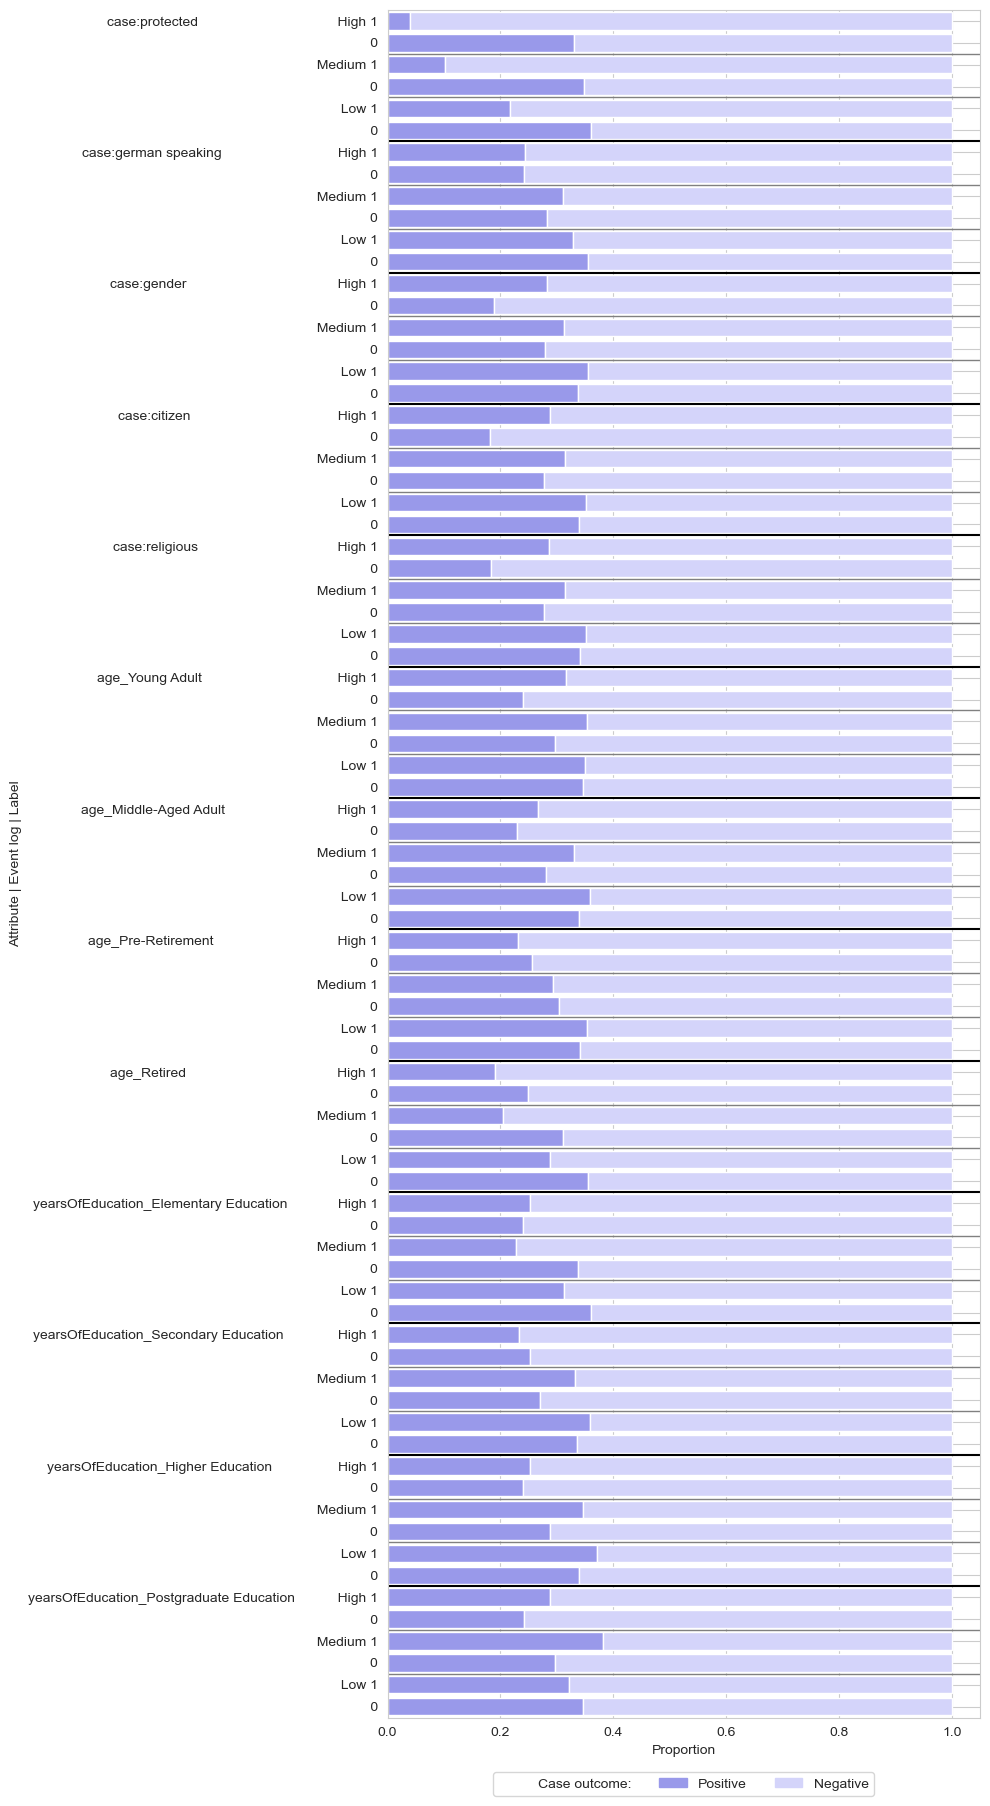

In [10]:
#Eliminate duplicates
df_hiring_log_high_semdpl = df_hiring_log_high.drop_duplicates(subset=['case:case'], keep='first')
df_hiring_log_medium_semdpl = df_hiring_log_medium.drop_duplicates(subset=['case:case'], keep='first')  
df_hiring_log_low_semdpl = df_hiring_log_low.drop_duplicates(subset=['case:case'], keep='first')   

plot_binary_attributes(df_hiring_log_high_semdpl, 
                       df_hiring_log_medium_semdpl, 
                       df_hiring_log_low_semdpl, 
                       attributes, 
                       ".//Figures//fig_hiring_log_atributtes.png",
                       attribute_label="Attribute",
                       target = 'Target',
                       fig_width=10,
                       fig_height=18)

Hospital

In [11]:
attributes = [
    'case:protected',
    'case:german speaking',
    'case:gender',
    'case:citizen',
    'case:private_insurance', 
    'case:underlying_condition',
    #age_Childhood',
    #'age_Adolescence',
    #'age_Youth',
    'age_Young Adult',
    'age_Middle-Aged Adult',
    'age_Pre-Retirement',
    'age_Retired',
]

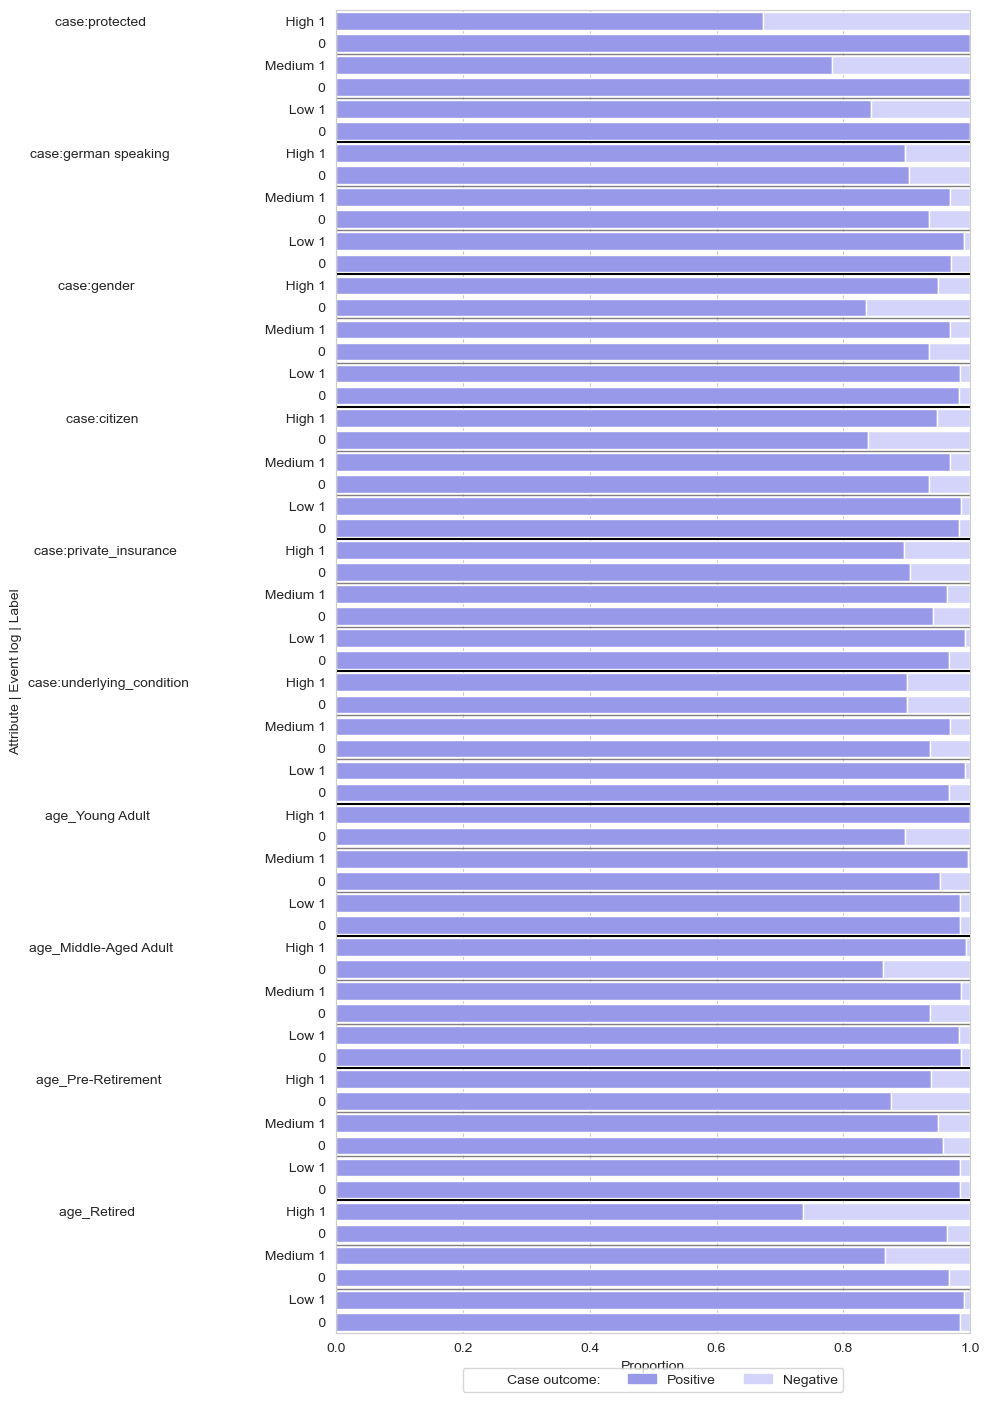

In [12]:
#Eliminate duplicates
df_hospital_log_high_semdpl = df_hospital_log_high.drop_duplicates(subset=['case:case'], keep='first')
df_hospital_log_medium_semdpl = df_hospital_log_medium.drop_duplicates(subset=['case:case'], keep='first')  
df_hospital_log_low_semdpl = df_hospital_log_low.drop_duplicates(subset=['case:case'], keep='first')   

plot_binary_attributes(df_hospital_log_high_semdpl, 
                       df_hospital_log_medium_semdpl, 
                       df_hospital_log_low_semdpl, 
                       attributes, 
                       ".//Figures//fig_hospital_log_atributtes.png",
                       attribute_label="Attribute",
                       target = 'Target',
                       fig_width=10,
                       fig_height=14)

Lending

In [13]:
#Rename variables
df_lending_log_high.rename(columns={
    'CreditScore_Moderado':  'CreditScore_Moderate',
    'CreditScore_Medio':     'CreditScore_Medium',
    'CreditScore_Alto':      'CreditScore_High',
    'CreditScore_Excelente': 'CreditScore_Excellent'
}, inplace=True)

df_lending_log_medium.rename(columns={
    'CreditScore_Moderado':  'CreditScore_Moderate',
    'CreditScore_Medio':     'CreditScore_Medium',
    'CreditScore_Alto':      'CreditScore_High',
    'CreditScore_Excelente': 'CreditScore_Excellent'
}, inplace=True)
   
df_lending_log_low.rename(columns={
    'CreditScore_Moderado':  'CreditScore_Moderate',
    'CreditScore_Medio':     'CreditScore_Medium',
    'CreditScore_Alto':      'CreditScore_High',
    'CreditScore_Excelente': 'CreditScore_Excellent'
}, inplace=True)

In [14]:
attributes = [
    'case:protected',
    'case:german speaking',
    'case:gender',
    'case:citizen',
    #'age_Childhood',
    #'age_Adolescence',
    #'age_Youth',
    'age_Young Adult',
    'age_Middle-Aged Adult',
    'age_Pre-Retirement',
    'age_Retired',
    #'yearsOfEducation_No Formal Education',
    'yearsOfEducation_Elementary Education',
    'yearsOfEducation_Secondary Education',
    'yearsOfEducation_Higher Education',
    'yearsOfEducation_Postgraduate Education',
    #'CreditScore_Baixo', 
    'CreditScore_Moderate', 
    'CreditScore_Medium', 
    'CreditScore_High', 
    'CreditScore_Excellent',
]

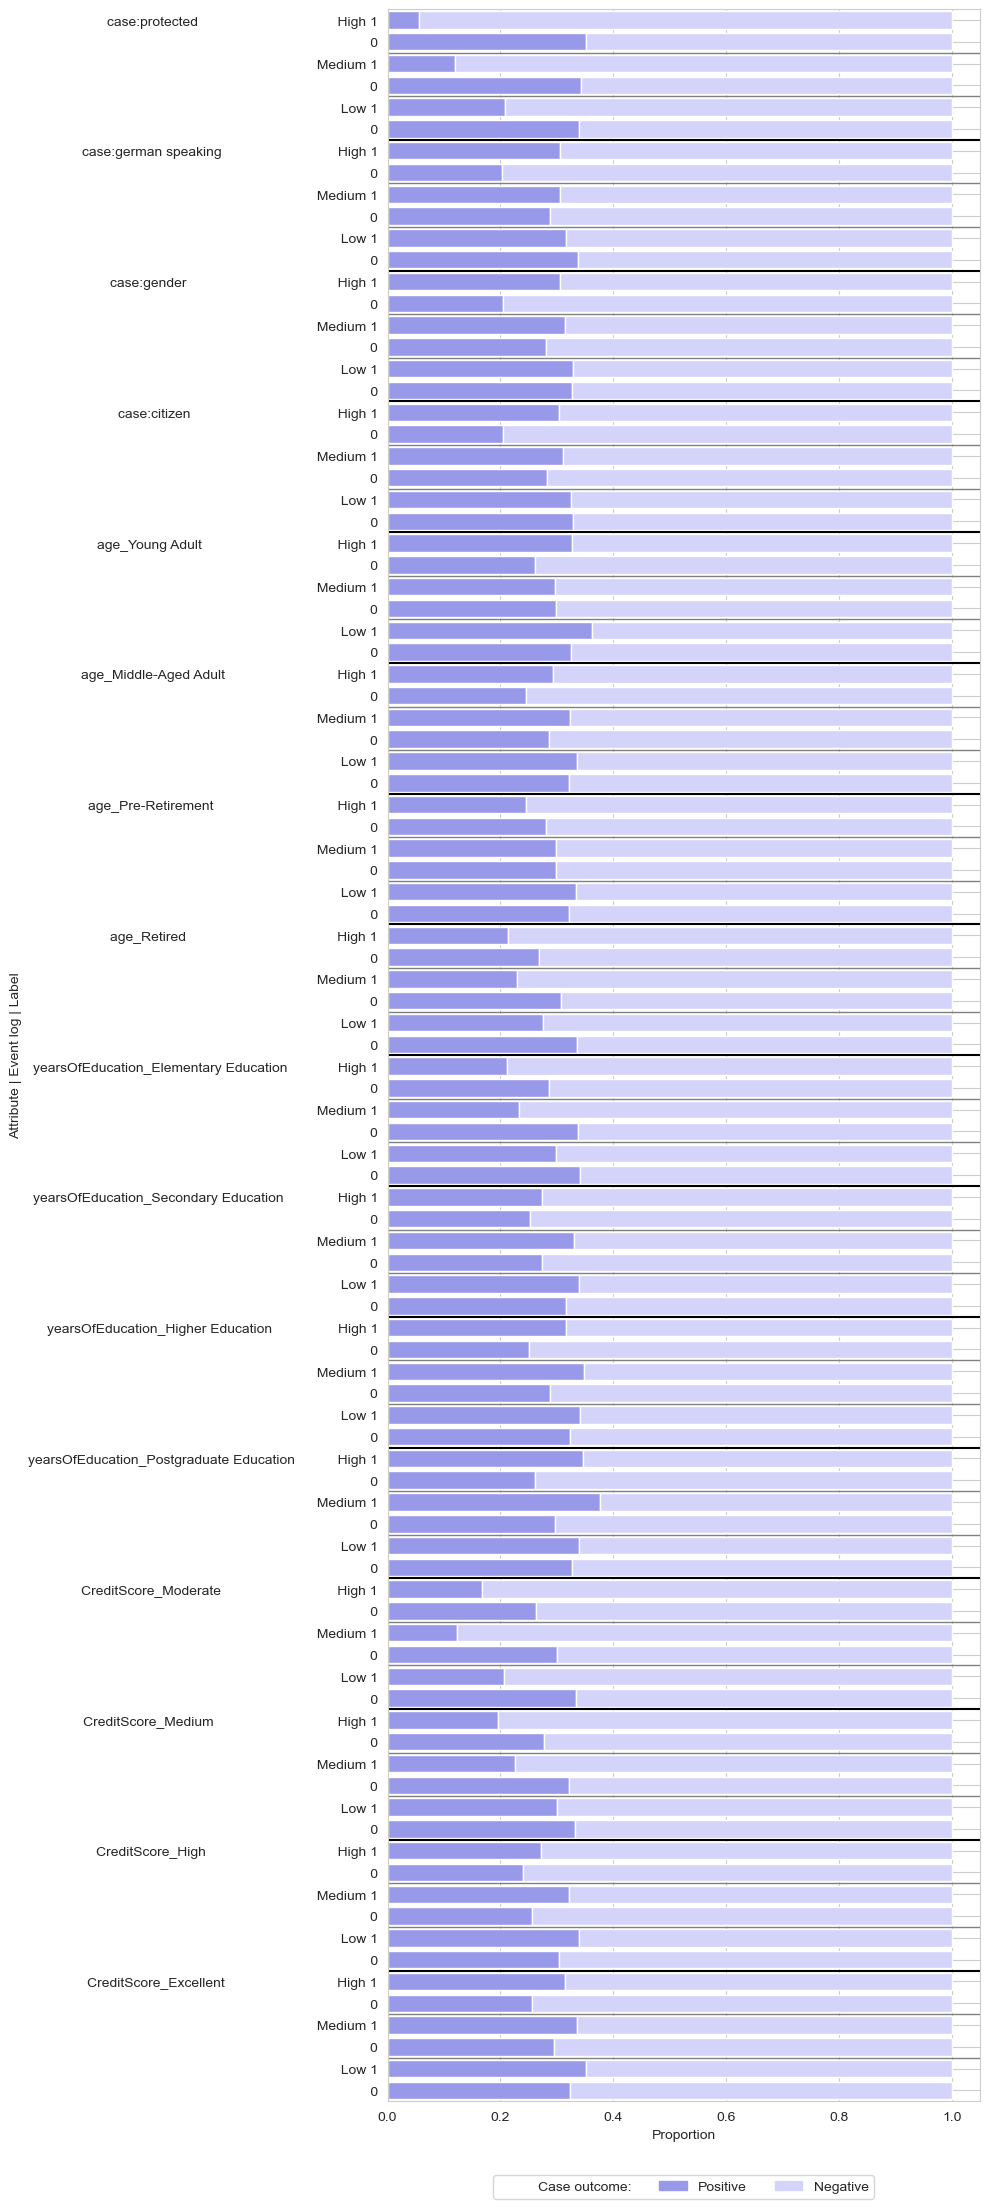

In [15]:
#Eliminate duplicates
df_lending_log_high_semdpl = df_lending_log_high.drop_duplicates(subset=['case:case'], keep='first')
df_lending_log_medium_semdpl = df_lending_log_medium.drop_duplicates(subset=['case:case'], keep='first')  
df_lending_log_low_semdpl = df_lending_log_low.drop_duplicates(subset=['case:case'], keep='first')   

plot_binary_attributes(df_lending_log_high_semdpl, 
                       df_lending_log_medium_semdpl, 
                       df_lending_log_low_semdpl, 
                       attributes, 
                       ".//Figures//fig_lending_log_atributtes.png",
                       attribute_label="Attribute",
                       target = 'Target',
                       fig_width=10,
                       fig_height=22)

Renting

In [16]:
attributes = [
    'case:protected',
    'case:german speaking',
    'case:gender',
    'case:citizen',
    'case:married',
    #'age_Childhood',
    #'age_Adolescence',
    #'age_Youth',
    'age_Young Adult',
    'age_Middle-Aged Adult',
    'age_Pre-Retirement',
    'age_Retired',
    #'yearsOfEducation_No Formal Education',
    'yearsOfEducation_Elementary Education',
    'yearsOfEducation_Secondary Education',
    'yearsOfEducation_Higher Education',
    'yearsOfEducation_Postgraduate Education'
]

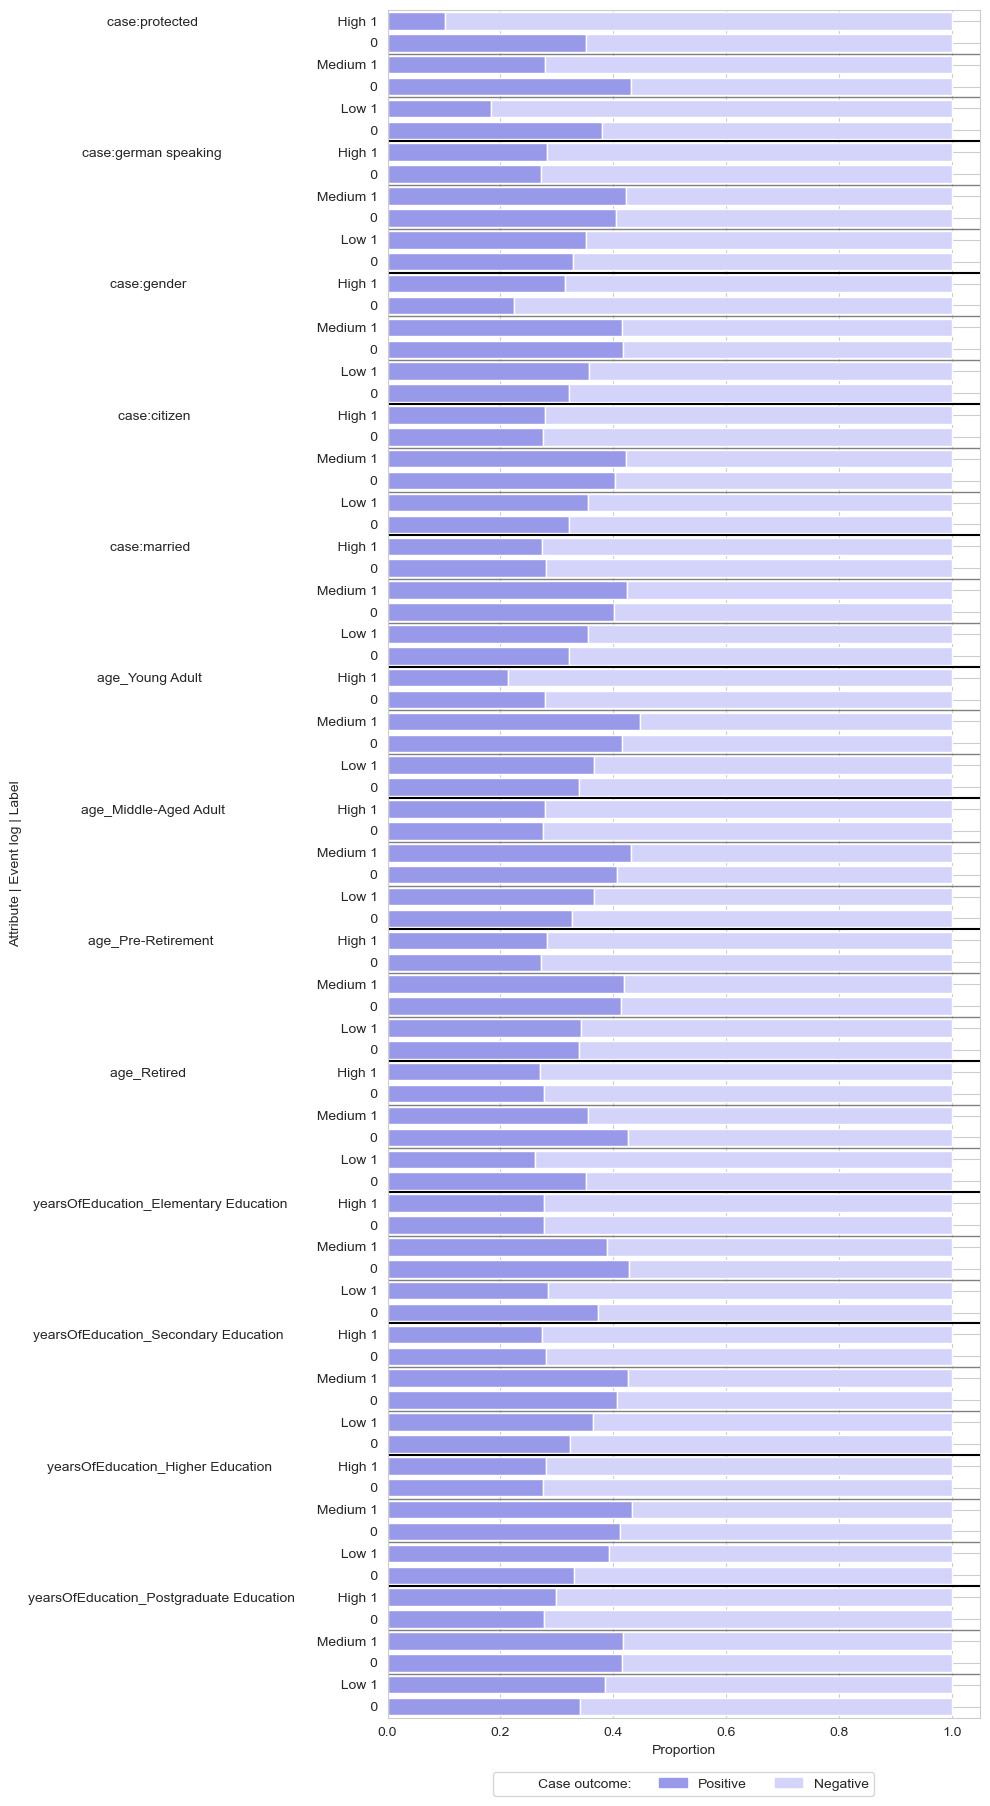

In [17]:
#Eliminate duplicates
df_renting_log_high_semdpl = df_renting_log_high.drop_duplicates(subset=['case:case'], keep='first')
df_renting_log_medium_semdpl = df_renting_log_medium.drop_duplicates(subset=['case:case'], keep='first')  
df_renting_log_low_semdpl = df_renting_log_low.drop_duplicates(subset=['case:case'], keep='first')   

plot_binary_attributes(df_renting_log_high_semdpl, 
                       df_renting_log_medium_semdpl, 
                       df_renting_log_low_semdpl, 
                       attributes, 
                       ".//Figures//fig_renting_log_atributtes.png",
                       attribute_label="Attribute",
                       target = 'Target',
                       fig_width=10,
                       fig_height=18)

### Analysis of transitions

<b> Functions

In [18]:
def plot_binary_transitions(df_log_high,
                            df_log_medium,
                            df_log_low,
                            attributes,
                            image_name,
                            attribute_label,
                            target,
                            fig_width,
                            fig_height,
                            protected_original):
    """
    Generates a stacked horizontal bar chart for binary attributes across
    three datasets (High, Medium, Low), considering only records where the
    transition occurred (attribute = 1). It adds a vertical red dashed line
    on each bar at the position defined in protected_original and includes a
    legend for this line (broken into two lines).
    """
    # --- Calculate proportions ---
    target_col = target
    result_rows = []
    for attr in attributes:
        row = {'Attribute': attr}
        for df_name, df in [('High', df_log_high),
                             ('Medium', df_log_medium),
                             ('Low', df_log_low)]:
            # Filter for records where the transition occurred (attribute == 1)
            filtered_df = df[df[attr] == 1]
            # Count positive (target=1) and negative (target=0) outcomes
            row[f'{df_name}_1'] = len(filtered_df[filtered_df[target_col] == 1])
            row[f'{df_name}_0'] = len(filtered_df[filtered_df[target_col] == 0])
        result_rows.append(row)
    result_df = pd.DataFrame(result_rows)

    plot_rows = []
    for _, row in result_df.iterrows():
        attr_name = row['Attribute']
        for base in ['High', 'Medium', 'Low']:
            t1 = row[f'{base}_1']
            t0 = row[f'{base}_0']
            total = t1 + t0
            prop_t1 = t1 / total if total > 0 else 0
            prop_t0 = t0 / total if total > 0 else 0
            # Create labels, giving the full attribute name only for the first base (High)
            label = f"{attr_name:<60}  {base}" if base == 'High' else f"  {base}"
            plot_rows.append({
                'attribute': attr_name,
                'base': base,
                'prop_t1': prop_t1,
                'prop_t0': prop_t0,
                'label_y': label
            })

    # --- Plotting ---
    y_pos = range(len(plot_rows))
    props1 = [d['prop_t1'] for d in plot_rows]
    props0 = [d['prop_t0'] for d in plot_rows]
    labels = [d['label_y'] for d in plot_rows]

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.barh(y_pos, props1, color='#9999ea', label='Protected group')
    ax.barh(y_pos, props0, left=props1, color='#d4d4fa', label='Unprotected group')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Proportion')
    ax.set_ylabel(f"{attribute_label} | Event log")
    ax.invert_yaxis()

    # --- Legends ---
    # Bar legends
    title_patch = mpatches.Patch(color='none', label='Protected Attribute')
    positive_patch = mpatches.Patch(color='#9999ea', label='Protected group')
    negative_patch = mpatches.Patch(color='#d4d4fa', label='Unprotected group')

    # Legend for the red dashed line (broken into two lines)
    red_line = Line2D([0], [0],
                      color='red',
                      lw=1,
                      linestyle='--',
                      label='Proportion of protected group\nin the complete event log')

    ax.legend(handles=[title_patch, positive_patch, negative_patch, red_line],
              loc='lower center',
              bbox_to_anchor=(0.2, -0.07),
              ncol=4)

    # --- Separator and indicator lines ---
    # Separator lines between attributes
    for i in range(len(plot_rows) - 1):
        if plot_rows[i]['attribute'] != plot_rows[i+1]['attribute']:
            ax.axhline(i + 0.5, color='black', linewidth=1.5)

    # Red dashed lines on each bar
    half_height = 0.4
    for i, item in enumerate(plot_rows):
        base = item['base']
        x_position = protected_original.get(base, None)
        if x_position is not None:
            ax.vlines(x_position,
                      i - half_height,
                      i + half_height,
                      colors='red',
                      linestyles='--',
                      linewidth=1)

    # --- Final adjustments and saving ---
    ax.set_ylim([len(plot_rows) - 0.5, -0.5])
    plt.tight_layout()
    plt.savefig(image_name, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [19]:
def ActivityTransitionsOneHotEncoding(df, id_col, activity_col, timestamp_col):
    """
    This function performs one-hot encoding for activity transitions in a process.
    Given a DataFrame containing case identifiers, activities, and timestamps,
    the function identifies the transitions from one activity to another within each case
    and creates a presence matrix of these transitions for each case. Additionally,
    the function returns the total count of each transition in the original DataFrame.
    """

    # Convert the timestamp column to datetime
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Sort by case ID and timestamp
    df = df.sort_values(by=[id_col, timestamp_col])

    # Identify the next activity for each event
    df['next_activity'] = df.groupby(id_col)[activity_col].shift(-1)

    # Create the transitions column
    df['transition'] = df[activity_col] + ' -> ' + df['next_activity']

    # Remove transitions where 'next_activity' is NaN (i.e., the last event of each case)
    df = df.dropna(subset=['next_activity'])
    
    # The following commented-out code is another way to exclude the last transition of each case
    # df['is_last'] = df.groupby(id_col).cumcount(ascending=False) == 0
    # df = df[~df['is_last']].copy()

    # Mark the presence of transitions per case
    transition_presence = df.groupby([id_col, 'transition']).size().reset_index(name='count')
    transition_presence['count'] = 1  # Replace the count with 1 to mark presence

    # Pivot the data to create the transition presence matrix
    transition_pivot = transition_presence.pivot(index=id_col, columns='transition', values='count').fillna(0)

    # Reset the index so that the case ID becomes a column
    transition_pivot = transition_pivot.reset_index()

    # Count the total of each transition in the original DataFrame
    transition_total_counts = df['transition'].value_counts().reset_index()
    transition_total_counts.columns = ['transition', 'total_count']

    return transition_pivot, transition_total_counts

Hiring

In [20]:
log_high_transitions, log_high_all_transitions = ActivityTransitionsOneHotEncoding(df_hiring_log_high, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')
log_medium_transitions, log_medium_all_transitions = ActivityTransitionsOneHotEncoding(df_hiring_log_medium, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')
log_low_transitions, log_low_all_transitions = ActivityTransitionsOneHotEncoding(df_hiring_log_low, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')

In [21]:
#Bring the transitions encoding to the dataframe
df_hiring_log_high = df_hiring_log_high.merge(log_high_transitions, on = 'case:case')
df_hiring_log_medium = df_hiring_log_medium.merge(log_medium_transitions, on = 'case:case')
df_hiring_log_low = df_hiring_log_low.merge(log_low_transitions, on = 'case:case')

In [22]:
attributes = ['Hand In Job Application -> Telephonic Screening',
             'Hand In Job Application -> Application Rejected',
             'Telephonic Screening -> Background Check',
             'Telephonic Screening -> Screening Interview',
             'Telephonic Screening -> Application Rejected', 
             'Background Check -> Screening Interview',  
             'Background Check -> Extensive Background Check',
             'Background Check -> Coding Interview',
             'Background Check -> Application Rejected',
             'Screening Interview -> Background Check',
             'Screening Interview -> Extensive Background Check',  
             'Screening Interview -> Coding Interview',
             'Screening Interview -> Application Rejected',
             'Extensive Background Check -> Coding Interview',             
             'Extensive Background Check -> Application Rejected',   
             'Coding Interview -> Backend Interview',
             'Coding Interview -> Frontend Interview',
             'Coding Interview -> ML Interview',
             'Coding Interview -> Application Rejected',
             'Backend Interview -> Frontend Interview',
             'Backend Interview -> ML Interview',             
             'Backend Interview -> Behavioral Interview',             
             'Backend Interview -> Application Rejected',  
             'Frontend Interview -> Backend Interview',
             'Frontend Interview -> ML Interview',
             'Frontend Interview -> Behavioral Interview',
             'Frontend Interview -> Application Rejected',
             'ML Interview -> Backend Interview',
             'ML Interview -> Frontend Interview',
             'ML Interview -> Behavioral Interview',
             'ML Interview -> Application Rejected',             
             'Behavioral Interview -> Behavioral Interview',
             'Behavioral Interview -> Make Job Offer',
             'Behavioral Interview -> Application Rejected',
             'Application Rejected -> Application Rejected',
             'Application Rejected -> Behavioral Interview',
             'Application Rejected -> Make Job Offer',
             'Make Job Offer -> Application Rejected',
             'Make Job Offer -> Make Job Offer'
]

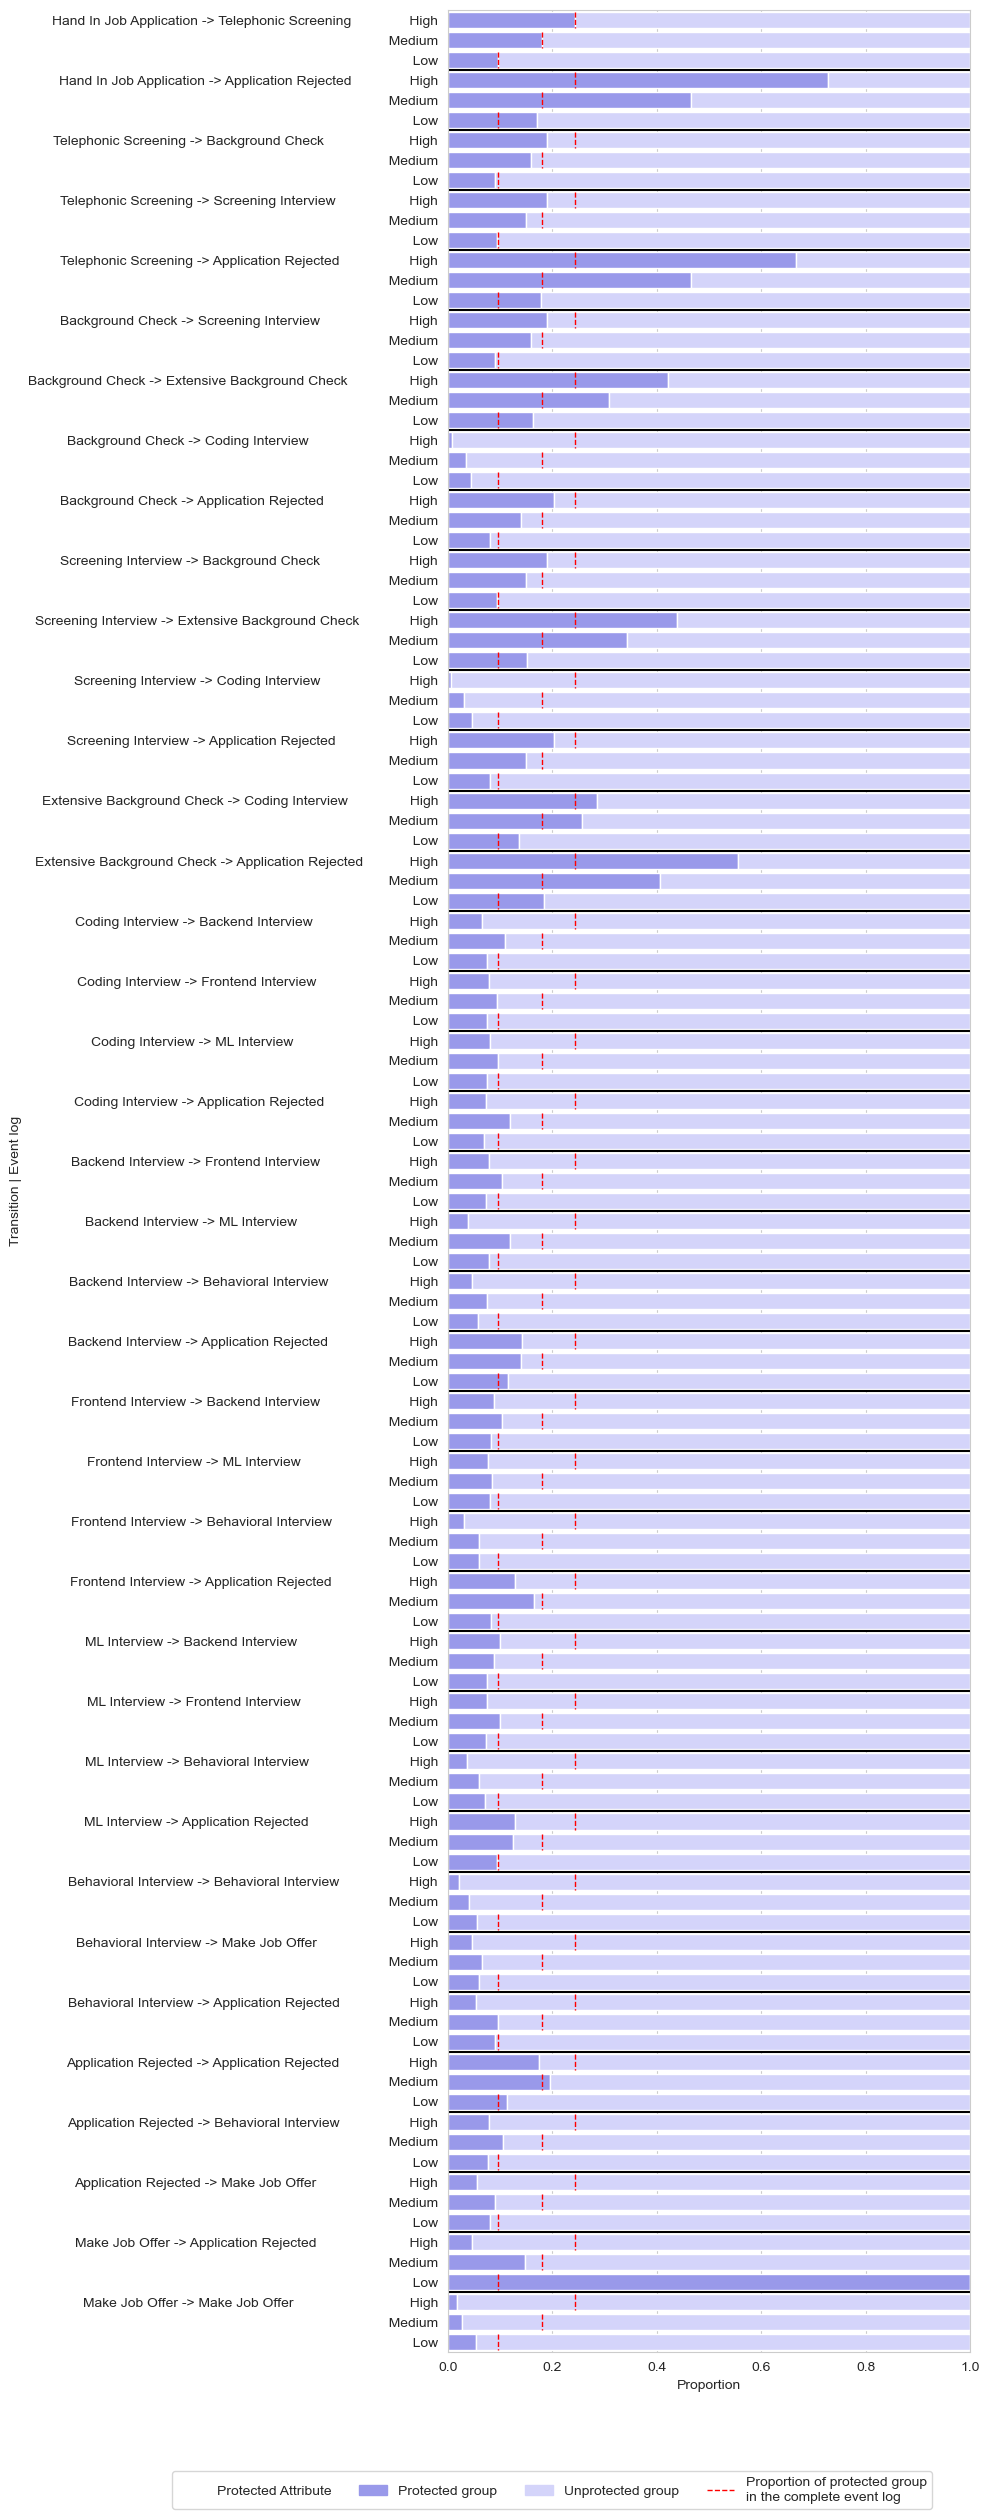

In [23]:
#Eliminate duplicates
df_hiring_log_high_semdpl = df_hiring_log_high.drop_duplicates(subset=['case:case'], keep='first')
df_hiring_log_medium_semdpl = df_hiring_log_medium.drop_duplicates(subset=['case:case'], keep='first')  
df_hiring_log_low_semdpl = df_hiring_log_low.drop_duplicates(subset=['case:case'], keep='first')   

protected_original_hiring = {'High': 0.2440, 'Medium': 0.1800, 'Low': 0.0966}

plot_binary_transitions(df_hiring_log_high_semdpl, 
                        df_hiring_log_medium_semdpl, 
                        df_hiring_log_low_semdpl, 
                        attributes, 
                        ".//Figures//fig_hiring_log_transitions.png",
                        attribute_label="Transition",
                        target = 'case:protected',
                        fig_width=10,
                        fig_height=25,
                        protected_original = protected_original_hiring)

Hospital

In [24]:
log_high_transitions, log_high_all_transitions = ActivityTransitionsOneHotEncoding(df_hospital_log_high, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')
log_medium_transitions, log_medium_all_transitions = ActivityTransitionsOneHotEncoding(df_hospital_log_medium, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')
log_low_transitions, log_low_all_transitions = ActivityTransitionsOneHotEncoding(df_hospital_log_low, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')

In [25]:
#Bring the transitions encoding to the dataframe
df_hospital_log_high = df_hospital_log_high.merge(log_high_transitions, on = 'case:case')
df_hospital_log_medium = df_hospital_log_medium.merge(log_medium_transitions, on = 'case:case')
df_hospital_log_low = df_hospital_log_low.merge(log_low_transitions, on = 'case:case')

In [26]:
attributes = ['Register at ER -> Examination',
             'Register at ER -> Expert Examination',
             'Register at ER -> Thorough Examination',  
             'Register at ER -> Diagnosis',
             'Register at FD -> Examination',
             'Register at FD -> Expert Examination',             
             'Register at FD -> Thorough Examination',             
             'Register at FD -> Diagnosis',
             'Examination -> Thorough Examination',
             'Examination -> Diagnosis',
             'Expert Examination -> Thorough Examination',
             'Expert Examination -> Diagnosis',
             'Thorough Examination -> Diagnosis',    
             'Diagnosis -> Treatment',
             'Treatment -> Treatment successful',
             'Treatment -> Treatment unsuccessful',
             'Treatment unsuccessful -> Diagnosis'
             #'Treatment -> Discharge',
]

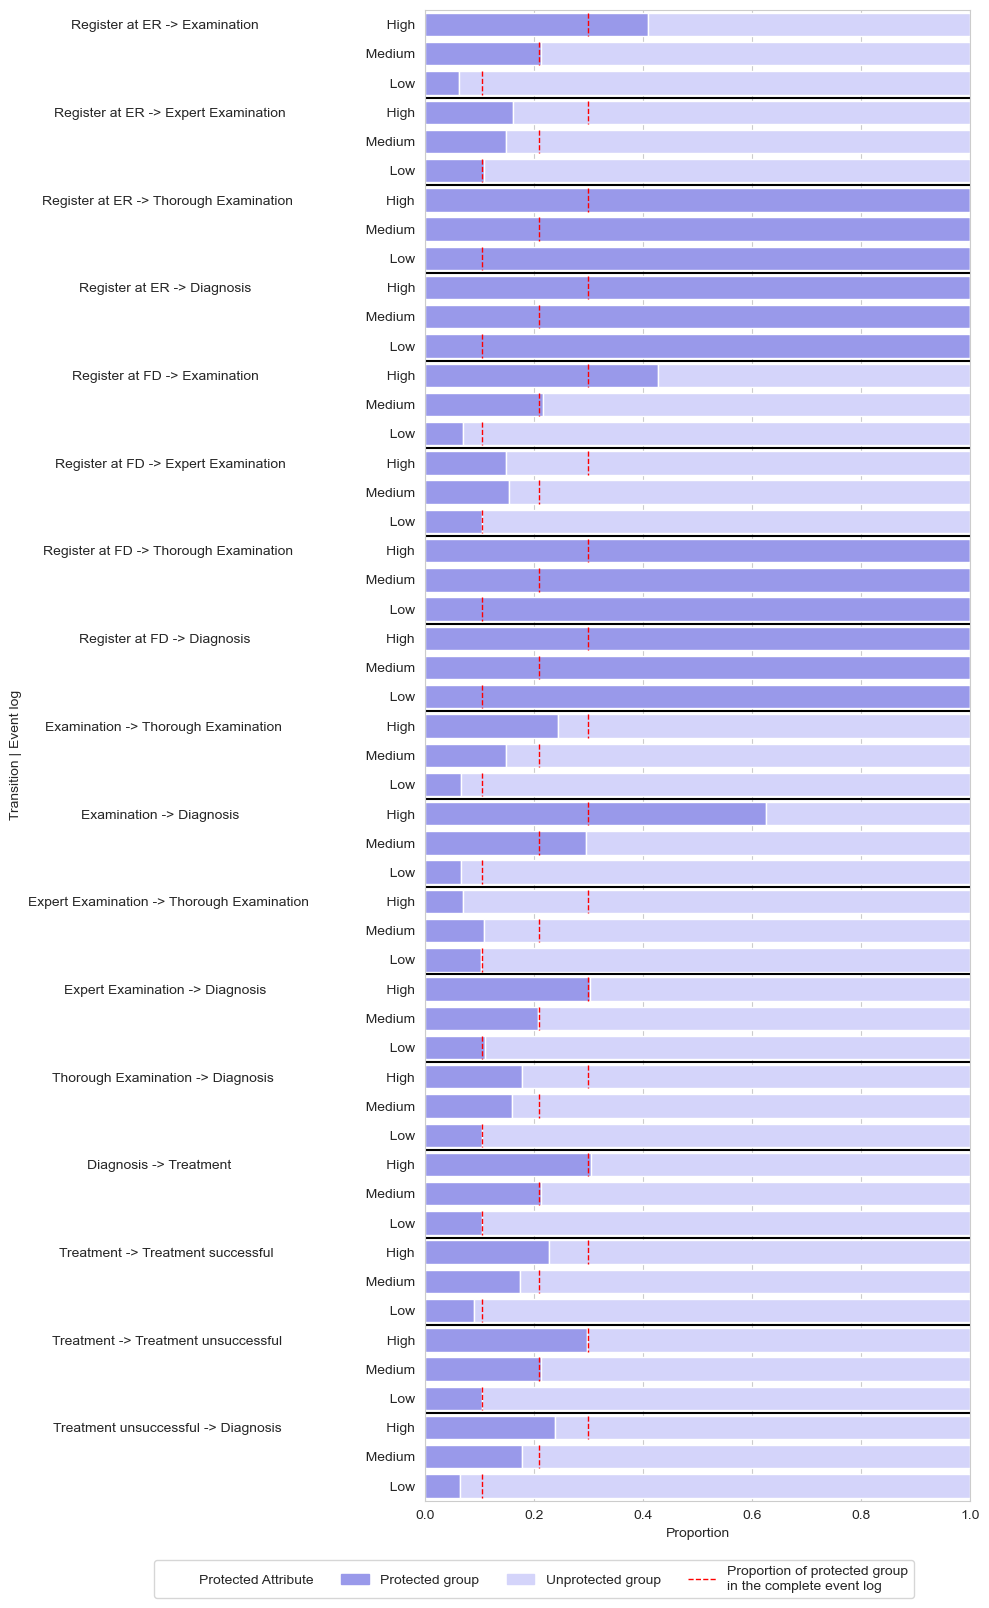

In [27]:
#Eliminate duplicates
df_hospital_log_high_semdpl = df_hospital_log_high.drop_duplicates(subset=['case:case'], keep='first')
df_hospital_log_medium_semdpl = df_hospital_log_medium.drop_duplicates(subset=['case:case'], keep='first')  
df_hospital_log_low_semdpl = df_hospital_log_low.drop_duplicates(subset=['case:case'], keep='first')   

protected_original_hospital = {'High': 0.2984, 'Medium': 0.2102, 'Low': 0.1047}

plot_binary_transitions(df_hospital_log_high_semdpl, 
                        df_hospital_log_medium_semdpl, 
                        df_hospital_log_low_semdpl, 
                        attributes, 
                        ".//Figures//fig_hospital_log_transitions.png",
                        attribute_label="Transition",
                        target = 'case:protected',
                        fig_width=10,
                        fig_height=16,
                        protected_original = protected_original_hospital)

Lending

In [28]:
log_high_transitions, log_high_all_transitions = ActivityTransitionsOneHotEncoding(df_lending_log_high, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')
log_medium_transitions, log_medium_all_transitions = ActivityTransitionsOneHotEncoding(df_lending_log_medium, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')
log_low_transitions, log_low_all_transitions = ActivityTransitionsOneHotEncoding(df_lending_log_low, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')

In [29]:
#Bring the transitions encoding to the dataframe
df_lending_log_high = df_lending_log_high.merge(log_high_transitions, on = 'case:case')
df_lending_log_medium = df_lending_log_medium.merge(log_medium_transitions, on = 'case:case')
df_lending_log_low = df_lending_log_low.merge(log_low_transitions, on = 'case:case')

In [30]:
attributes = ['Request Appointment -> Set Appointment',
             'Request Appointment -> Appointment Denied',    
             'Set Appointment -> Hand In Credit Appliaction',
             'Hand In Credit Appliaction -> Verify Borrowers Information',             
             'Verify Borrowers Information -> Make Visit to Assess Colatteral',
             'Verify Borrowers Information -> Request Co-Signer On Loan',
             'Verify Borrowers Information -> Submit File to Underwriter',
             'Verify Borrowers Information -> skipped_examination',
             'Verify Borrowers Information -> Application Rejected',    
             'Make Visit to Assess Colatteral -> Make Visit to Assess Colatteral',
             'Make Visit to Assess Colatteral -> Request Co-Signer On Loan',
             'Make Visit to Assess Colatteral -> Submit File to Underwriter',             
             'Request Co-Signer On Loan -> Make Visit to Assess Colatteral',
             'Request Co-Signer On Loan -> Submit File to Underwriter',
             'Submit File to Underwriter -> Sign Loan Agreement',
             'Submit File to Underwriter -> Loan Denied',
             'skipped_examination -> Sign Loan Agreement'
]

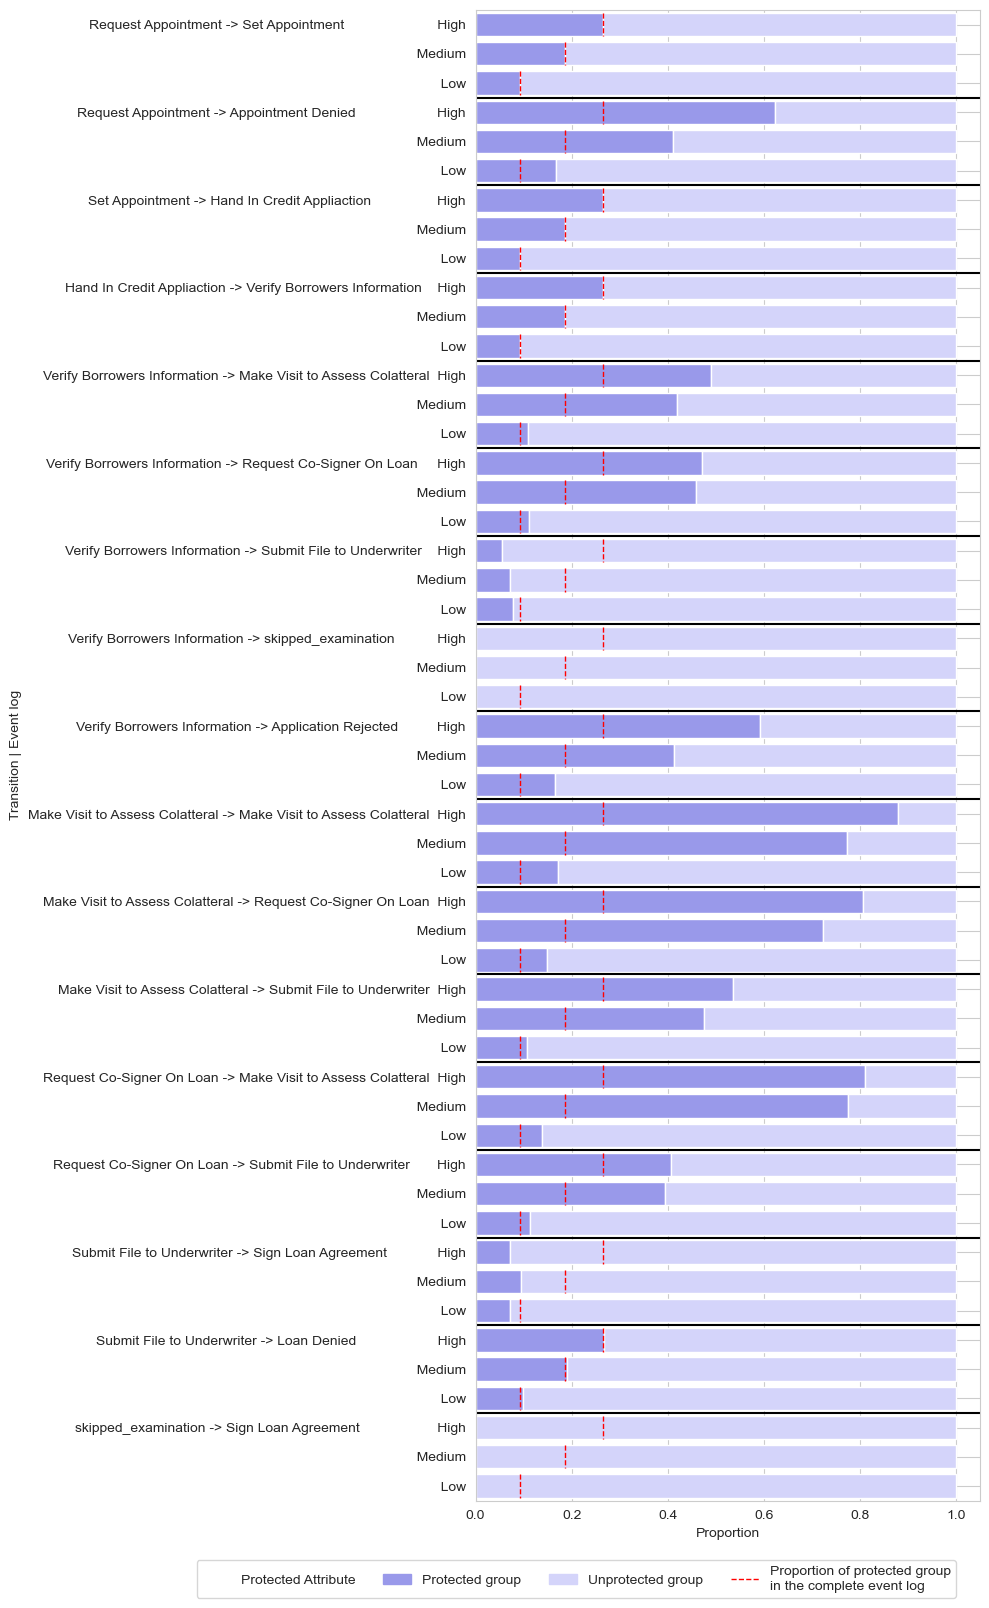

In [31]:
#Eliminate duplicates
df_lending_log_high_semdpl = df_lending_log_high.drop_duplicates(subset=['case:case'], keep='first')
df_lending_log_medium_semdpl = df_lending_log_medium.drop_duplicates(subset=['case:case'], keep='first')  
df_lending_log_low_semdpl = df_lending_log_low.drop_duplicates(subset=['case:case'], keep='first')   

protected_original_lending = {'High': 0.2658, 'Medium': 0.1853, 'Low': 0.0932}

plot_binary_transitions(df_lending_log_high_semdpl, 
                        df_lending_log_medium_semdpl, 
                        df_lending_log_low_semdpl, 
                        attributes, 
                        ".//Figures//fig_lending_log_transitions.png",
                        attribute_label="Transition",
                        target = 'case:protected',
                        fig_width=10,
                        fig_height=16,
                        protected_original = protected_original_lending)

Renting

In [32]:
log_high_transitions, log_high_all_transitions = ActivityTransitionsOneHotEncoding(df_renting_log_high, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')
log_medium_transitions, log_medium_all_transitions = ActivityTransitionsOneHotEncoding(df_renting_log_medium, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')
log_low_transitions, log_low_all_transitions = ActivityTransitionsOneHotEncoding(df_renting_log_low, id_col = 'case:case', activity_col = 'activity', timestamp_col = 'time:timestamp')

In [33]:
#Bring the transitions encoding to the dataframe
df_renting_log_high = df_renting_log_high.merge(log_high_transitions, on = 'case:case')
df_renting_log_medium = df_renting_log_medium.merge(log_medium_transitions, on = 'case:case')
df_renting_log_low = df_renting_log_low.merge(log_low_transitions, on = 'case:case')

In [34]:
attributes = ['Apply for Viewing Appointment -> Set Appointment',
             'Apply for Viewing Appointment -> Reject Prospective Tenant',
             'Set Appointment -> View The Property',             
             'View The Property -> Hand In The Paperwork',             
             'View The Property -> Reject Prospective Tenant',
             'Hand In The Paperwork -> Check Paperwork',             
             'Check Paperwork -> Screen Prospective Tenant',
             'Screen Prospective Tenant -> Extensive Screening',
             'Screen Prospective Tenant -> Sign Contract',      
             'Screen Prospective Tenant -> Reject Prospective Tenant',
             'Extensive Screening -> Sign Contract',
             'Extensive Screening -> Reject Prospective Tenant'
]

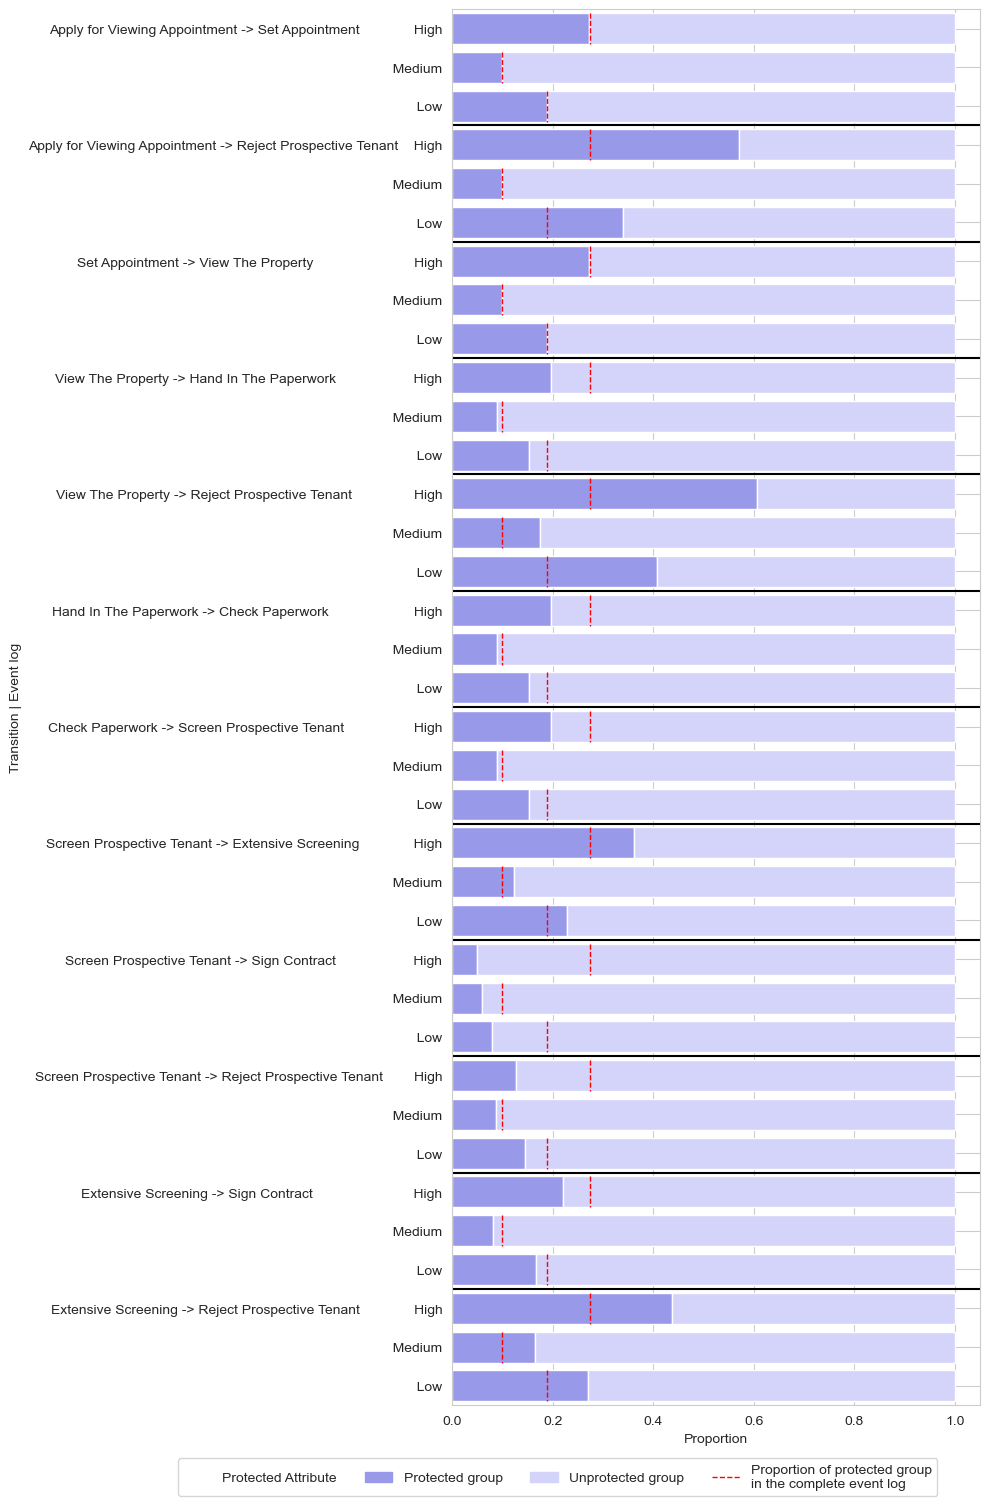

In [35]:
#Eliminate duplicates
df_renting_log_high_semdpl = df_renting_log_high.drop_duplicates(subset=['case:case'], keep='first')
df_renting_log_medium_semdpl = df_renting_log_medium.drop_duplicates(subset=['case:case'], keep='first')  
df_renting_log_low_semdpl = df_renting_log_low.drop_duplicates(subset=['case:case'], keep='first')   

protected_original_renting = {'High': 0.2736, 'Medium': 0.0993, 'Low': 0.1896}

plot_binary_transitions(df_renting_log_high_semdpl, 
                        df_renting_log_medium_semdpl, 
                        df_renting_log_low_semdpl, 
                        attributes, 
                        ".//Figures//fig_renting_log_transitions.png",
                        attribute_label="Transition",
                        target = 'case:protected',
                        fig_width=10,
                        fig_height=15,
                        protected_original = protected_original_renting)

### Analysis of results

<b> Import databases

In [36]:
df_hiring_results = pd.read_excel(os.path.join(dir_hiring_log, f'hiring_log_metrics.xlsx'))
df_hospital_results = pd.read_excel(os.path.join(dir_hospital_log, f'hospital_log_metrics.xlsx'))
df_lending_results = pd.read_excel(os.path.join(dir_lending_log, f'lending_log_metrics.xlsx'))
df_renting_results = pd.read_excel(os.path.join(dir_renting_log, f'renting_log_metrics.xlsx'))

In [37]:
# Consolidate the datasets
datasets = [
    (df_hiring_results, "Hiring"),
    (df_hospital_results, "Hospital"),
    (df_lending_results, "Lending"),
    (df_renting_results, "Renting"),
]

results_list = []
for df, process_name in datasets:
    # 1) Filter for test results only (Source == 'Test')
    df_test = df[df["Source"] == "Test"].copy()
    
    # 2) Pivot the table to have each metric in a separate column
    wide_df = (
        df_test
        .pivot(index=["Type", "Dataset"], columns="Metric", values="Value")
        .reset_index()
    )
    
    # 3) Keep only the columns of interest (in case there are other metrics)
    columns_to_keep = [
        "Type", "Dataset",
        "F1-Score", "Max Difference - Demographic Parity", "Disparate Impact",
        "Max Difference - Equalized Odds (FPR)", "Max Difference - Equalized Odds (TPR)"
    ]
    wide_df = wide_df[columns_to_keep]
    
    
    # 4) Rename columns for clarity
    wide_df = wide_df.rename(columns={
        "Type": "Model",
        "Dataset": "Base",
        "F1-Score": "F1-Score",
        "Max Difference - Demographic Parity": "Demographic Parity",
        "Disparate Impact": "Disparate Impact",
        "Max Difference - Equalized Odds (FPR)": "Equalized Odds (FPR)",
        "Max Difference - Equalized Odds (TPR)": "Equalized Odds (TPR)",
    })
    
    
    # 5) Add the process name column at the beginning
    wide_df.insert(0, "Process", process_name)
    
    results_list.append(wide_df)

# 6) Concatenate all results into a single DataFrame
df_results = pd.concat(results_list, ignore_index=True)

# 7) (Optional) Reorder the columns for the final presentation
df_results = df_results[
    ["Process", "Base", "Model", 
     "F1-Score", "Demographic Parity", "Disparate Impact",
     "Equalized Odds (FPR)", "Equalized Odds (TPR)"]
]

# Display the first few rows of the final DataFrame
df_results.head()

Metric,Process,Base,Model,F1-Score,Demographic Parity,Disparate Impact,Equalized Odds (FPR),Equalized Odds (TPR)
0,Hiring,High,Baseline,0.967536,0.333793,0.17156,0.056435,0
1,Hiring,Low,Baseline,0.998587,0.140865,0.622092,0.018519,0
2,Hiring,Medium,Baseline,0.980587,0.297622,0.268159,0.008968,0
3,Hiring,High,In-processing: Adversarial Debiasing,0.740715,0.012278,1.108003,0.046675,0.724618
4,Hiring,Low,In-processing: Adversarial Debiasing,0.998587,0.140865,0.622092,0.018519,0


In [38]:
# Insert results from the reference model
new_data = [
    {"Process": "Hiring",   "Base": "High",   "Model": "Reference", "F1-Score": "0,39", "Demographic Parity": "0,06"},
    {"Process": "Hiring",   "Base": "Medium", "Model": "Reference", "F1-Score": "0,64", "Demographic Parity": "0,17"},
    {"Process": "Hiring",   "Base": "Low",    "Model": "Reference", "F1-Score": "0,63", "Demographic Parity": "0,09"},
    {"Process": "Hospital", "Base": "High",   "Model": "Reference", "F1-Score": "0,95", "Demographic Parity": "0,00"},
    {"Process": "Hospital", "Base": "Medium", "Model": "Reference", "F1-Score": "0,97", "Demographic Parity": "0,00"},
    {"Process": "Hospital", "Base": "Low",    "Model": "Reference", "F1-Score": "0,99", "Demographic Parity": "0,00"},
    {"Process": "Lending",  "Base": "High",   "Model": "Reference", "F1-Score": "0,12", "Demographic Parity": "0,00"},
    {"Process": "Lending",  "Base": "Medium", "Model": "Reference", "F1-Score": "0,01", "Demographic Parity": "0,00"},
    {"Process": "Lending",  "Base": "Low",    "Model": "Reference", "F1-Score": "0,02", "Demographic Parity": "0,00"},
    {"Process": "Renting",  "Base": "High",   "Model": "Reference", "F1-Score": "0,28", "Demographic Parity": "0,00"},
    {"Process": "Renting",  "Base": "Medium", "Model": "Reference", "F1-Score": "0,43", "Demographic Parity": "0,00"},
    {"Process": "Renting",  "Base": "Low",    "Model": "Reference", "F1-Score": "0,36", "Demographic Parity": "0,02"},
]

# Create a temporary DataFrame from the new data
new_rows_df = pd.DataFrame(new_data)

# Convert commas to periods and cast the columns to float
for col in ["F1-Score", "Demographic Parity"]:
    new_rows_df[col] = new_rows_df[col].str.replace(",", ".").astype(float)

# Add missing columns with None values for Disparate Impact and Equalized Odds
for col in ["Disparate Impact", "Equalized Odds (FPR)", "Equalized Odds (TPR)"]:
    new_rows_df[col] = None

# Concatenate the new rows to the main results DataFrame
df_results = pd.concat([df_results, new_rows_df], ignore_index=True)

# Display the new shape of the DataFrame
df_results.shape

(129, 8)

In [39]:
# 1) Define the desired order for the "Base" column
base_categories = ["High", "Medium", "Low"]
df_results["Base"] = pd.Categorical(
    df_results["Base"],
    categories=base_categories,
    ordered=True
)

# 2) Sort the DataFrame by "Process" and then by the new "Base" order
df_results = df_results.sort_values(
    by=["Process", "Base"]
).reset_index(drop=True)

# Save the final DataFrame to an Excel file
df_results.to_excel('./Figures/df_results.xlsx')

# Display the shape of the sorted DataFrame
df_results.shape

(129, 8)

In [40]:
# List of tuples (DataFrame, process name)
datasets = [
    (df_hiring_results, "Hiring"),
    (df_hospital_results, "Hospital"),
    (df_lending_results, "Lending"),
    (df_renting_results, "Renting"),
]

# Define scalar and vector metrics
scalar_metrics = [
    "F1-Score",
    "Max Difference - Equalized Odds (TPR)",
    "Max Difference - Equalized Odds (FPR)",
]
vector_metrics = [
    "Equalized Odds (TPR)",
    "Equalized Odds (FPR)",
]

rows = []
for df, process_name in datasets:
    df_test = df[df["Source"] == "Test"]
    for (model_type, dataset_name), group in df_test.groupby(["Type", "Dataset"]):
        record = {
            "Process": process_name,
            "Base": dataset_name,
            "Model": model_type,
        }
        # Extract scalar values
        for metric in scalar_metrics:
            values = group.loc[group["Metric"] == metric, "Value"]
            record[metric] = values.iloc[0] if not values.empty else None

        # Extract vector values
        for metric in vector_metrics:
            values = group.loc[group["Metric"] == metric, "Value"]
            if values.empty:
                record[f"{metric}_case:protected_1"] = None
                record[f"{metric}_case:protected_0"] = None
            else:
                raw_value = values.iloc[0]
                # If it's a string, convert it
                if isinstance(raw_value, str):
                    # Expects something like "{0: 0.8, 1: 0.6}" or similar
                    try:
                        parsed_dict = ast.literal_eval(raw_value)
                    except Exception:
                        # If it's a string representation of a Series, convert to dict manually
                        # e.g.: "0   0.8\n1   0.6\n"
                        lines = [l.strip() for l in raw_value.splitlines() if l and l[0].isdigit()]
                        parsed_dict = {}
                        for line in lines:
                            key, val = line.split()
                            parsed_dict[int(key)] = float(val)
                else:
                    parsed_dict = raw_value  # It's already a dict or Series

                # Extract protected=1 and =0 values
                record[f"{metric}_case:protected_1"] = parsed_dict.get(1, None)
                record[f"{metric}_case:protected_0"] = parsed_dict.get(0, None)

        rows.append(record)

# Build the final DataFrame with a specific column order
final_df = pd.DataFrame(rows, columns=[
    "Process", "Base", "Model",
    "F1-Score",
    "Max Difference - Equalized Odds (TPR)",
    "Equalized Odds (TPR)_case:protected_1",
    "Equalized Odds (TPR)_case:protected_0",
    "Max Difference - Equalized Odds (FPR)",
    "Equalized Odds (FPR)_case:protected_1",
    "Equalized Odds (FPR)_case:protected_0",
])

# Display the first few rows
final_df.head()

# Save the DataFrame to an Excel file
final_df.to_excel('./Figures/df_tpr_fpr_analysis.xlsx')

<b> Visualização

Demographic Parity: diferença entre a quantidade de predições favoráveis para cada grupo.

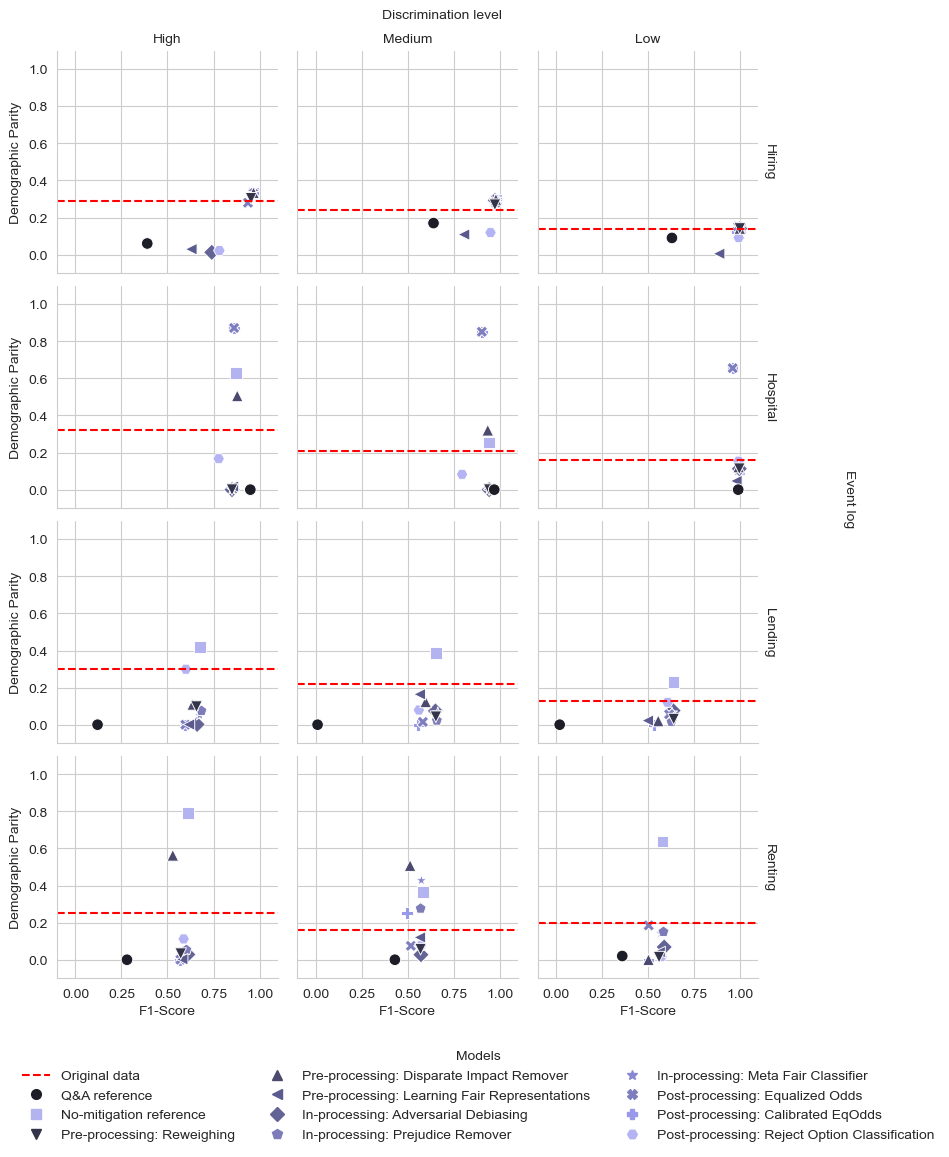

In [41]:
# df = df_results[df_results['Model'] != 'Baseline']

# Replace model names for better readability in the plot
df_results['Model'] = df_results['Model'].replace({
    'Reference': 'Q&A reference',
    'Baseline':  'No-mitigation reference'
})
df = df_results

# --- Dictionaries for plot styling ---

# Dictionary for markers
markers_dict = {
    "Q&A reference": "o",
    "No-mitigation reference": "s",
    "Pre-processing: Reweighing": "v",                      
    "Pre-processing: Disparate Impact Remover": "^",      
    "Pre-processing: Learning Fair Representations": "<", 
    "In-processing: Adversarial Debiasing": "D", 
    "In-processing: Prejudice Remover": "p", 
    "In-processing: Meta Fair Classifier": "*", 
    "Post-processing: Equalized Odds": "X",                      
    "Post-processing: Calibrated EqOdds": "P",                 
    "Post-processing: Reject Option Classification": "H"       
}

# Dictionary for colors
colors_dict = {
    "Q&A reference": "#1d1d27",
    "No-mitigation reference": "#b3b3f0",
    "Pre-processing: Reweighing": "#333349",
    "Pre-processing: Disparate Impact Remover": "#4b4a6e",
    "Pre-processing: Learning Fair Representations": "#5a5a8f",  
    "In-processing: Adversarial Debiasing": "#646395",
    "In-processing: Prejudice Remover": "#7d7cb9", 
    "In-processing: Meta Fair Classifier": "#8887d1",
    "Post-processing: Equalized Odds": "#7e7ebf",
    "Post-processing: Calibrated EqOdds": "#9999ea",
    "Post-processing: Reject Option Classification": "#b4b4f4" 
}

# Dictionary for baselines
# The key is (Process, Base), and the value is the Demographic Parity baseline.
baseline_dict = {
    ("Hiring", "High"): 0.29,
    ("Hiring", "Medium"): 0.24,
    ("Hiring", "Low"): 0.14,
    ("Hospital", "High"): 0.32,
    ("Hospital", "Medium"): 0.21,
    ("Hospital", "Low"): 0.16,
    ("Lending", "High"): 0.30,
    ("Lending", "Medium"): 0.22,
    ("Lending", "Low"): 0.13,
    ("Renting", "High"): 0.25,
    ("Renting", "Medium"): 0.16,
    ("Renting", "Low"): 0.20,
}

# ──────────────────────────────────────────────────────────────────────────────
# 1) PREPARE ALL LEGEND HANDLES
# ──────────────────────────────────────────────────────────────────────────────

# Handles for each model (using the same color and marker as the scatter plot)
model_handles = [
    Line2D([], [],                     # Empty list = nothing to plot
           marker=markers_dict[m],     # Model's marker
           color='none',               # Invisible line
           markerfacecolor=colors_dict[m],
           markeredgecolor=colors_dict[m],
           markersize=7,
           linestyle='',               # No line
           label=m)                    # Text for the legend
    for m in markers_dict
]

# Handle for the red dashed line (baseline)
baseline_handle = Line2D([], [],
                         color='red',
                         linestyle='--',
                         linewidth=1.5,
                         label='Original data')

# Join all handles into a single list
legend_handles = [baseline_handle] + model_handles

# ──────────────────────────────────────────────────────────────────────────────
# 2) CREATE AND DRAW THE FACETGRID
# ──────────────────────────────────────────────────────────────────────────────

g = sns.FacetGrid(
    data=df,
    row="Process",
    col="Base",
    margin_titles=True
)

def facet_scatter(data, **kwargs):
    # Draw the scatter plot points
    sns.scatterplot(
        data=data,
        x="F1-Score",
        y="Demographic Parity",
        hue="Model",
        style="Model",
        markers=markers_dict,
        palette=colors_dict,
        s=70,
        **kwargs
    )
    
    # Draw the red dashed baseline line for each facet
    current_process = data["Process"].iloc[0]
    current_base = data["Base"].iloc[0]
    if (current_process, current_base) in baseline_dict:
        plt.axhline(
            y=baseline_dict[(current_process, current_base)],
            color='red',
            linestyle='--',
            linewidth=1.5
        )

g.map_dataframe(facet_scatter)

# ──────────────────────────────────────────────────────────────────────────────
# 3) CUSTOMIZE LEGEND AND TITLES
# ──────────────────────────────────────────────────────────────────────────────

# Add the legend with all custom handles
g.add_legend(
    handles=legend_handles,          # Includes models + baseline handle
    title="Models",                  # General title for the legend
    ncol=3,
    loc="upper center",
    bbox_to_anchor=(0.3, 0.15)       # Position below the plot
)

# Set axis limits
g.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))

# Remove "Process = " and "Base = " prefixes from facet titles
g.set_titles(row_template='{row_name}', col_template='{col_name}')

# Adjust space at the bottom to make room for the legend
plt.subplots_adjust(bottom=0.2)

# General title for the column axis
g.fig.text(
    0.28,
    1.0,
    'Discrimination level', 
    ha='center'
)

# General title for the row axis
g.fig.text(
    0.5,
    0.6,
    'Event log',
    va='center',
    rotation=-90
)

# Save and show the plot
plt.savefig("./Figures/fig_metric_DemographicParity.png", dpi=300, bbox_inches="tight")
plt.show()

Disparate impact: razão entre a quantidade de predições favoráveis para cada grupo.

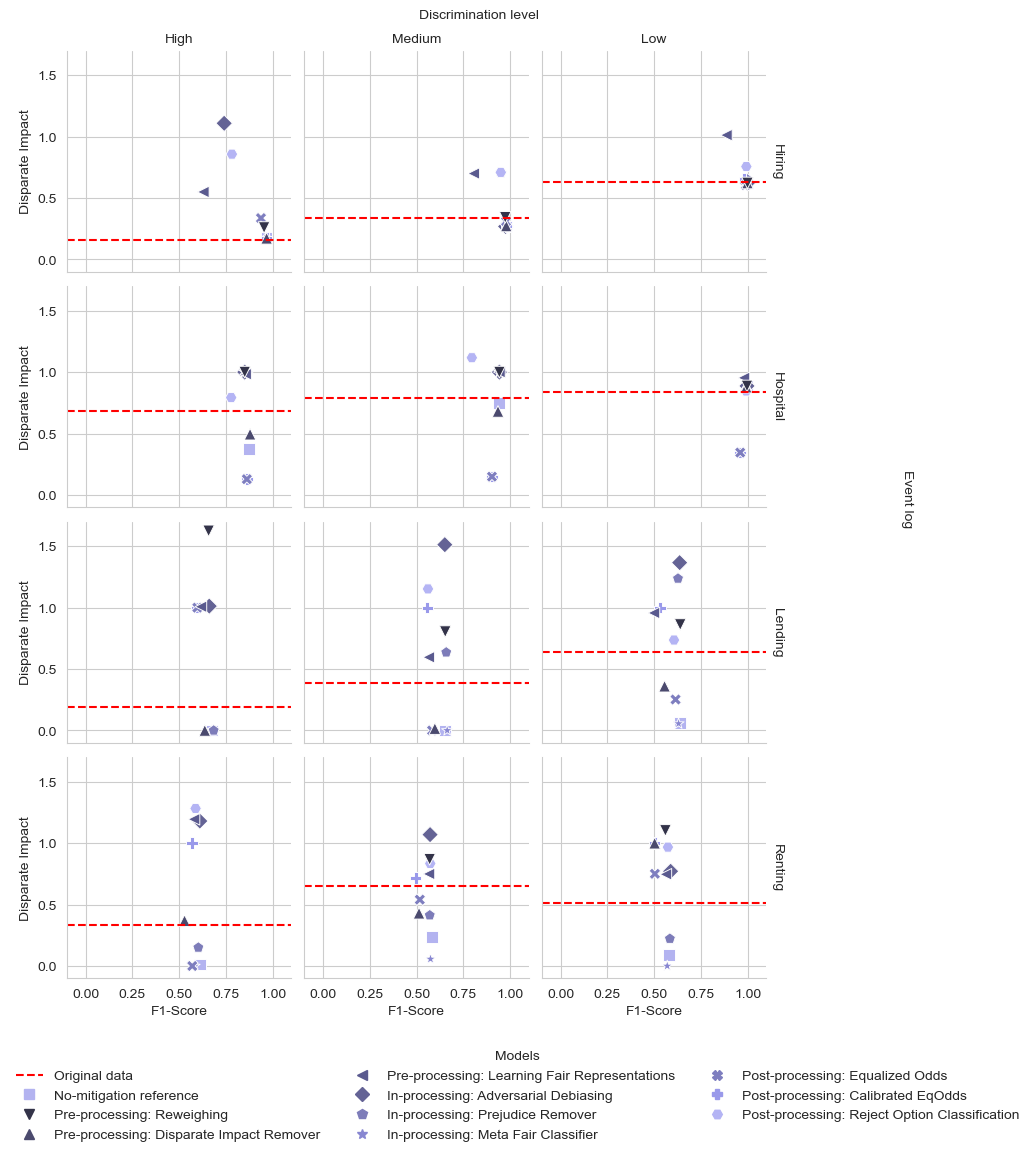

In [42]:
# df2 = df_results[(df_results['Model'] != 'Baseline')]
# df2 = df2[(df2['Model'] != 'Reference')]

# Filter out the 'Q&A reference' model for this plot
df2 = df_results[(df_results['Model'] != 'Q&A reference')]

# --- Dictionaries for plot styling ---

# Dictionary for markers
markers_dict = {
    #"Q&A reference": "o",
    "No-mitigation reference": "s",
    "Pre-processing: Reweighing": "v",                      
    "Pre-processing: Disparate Impact Remover": "^",      
    "Pre-processing: Learning Fair Representations": "<", 
    "In-processing: Adversarial Debiasing": "D", 
    "In-processing: Prejudice Remover": "p", 
    "In-processing: Meta Fair Classifier": "*", 
    "Post-processing: Equalized Odds": "X",                      
    "Post-processing: Calibrated EqOdds": "P",                 
    "Post-processing: Reject Option Classification": "H"       
}

# Dictionary for colors
colors_dict = {
    #"Q&A reference": "#1d1d27",
    "No-mitigation reference": "#b3b3f0",
    "Pre-processing: Reweighing": "#333349",
    "Pre-processing: Disparate Impact Remover": "#4b4a6e",
    "Pre-processing: Learning Fair Representations": "#5a5a8f",  
    "In-processing: Adversarial Debiasing": "#646395",
    "In-processing: Prejudice Remover": "#7d7cb9", 
    "In-processing: Meta Fair Classifier": "#8887d1",
    "Post-processing: Equalized Odds": "#7e7ebf",
    "Post-processing: Calibrated EqOdds": "#9999ea",
    "Post-processing: Reject Option Classification": "#b4b4f4" 
}


# Dictionary for baselines:
# The key is (Process, Base), and the value is the Disparate Impact baseline.
baseline_dict = {
    ("Hiring", "High"): 0.16,
    ("Hiring", "Medium"): 0.34,
    ("Hiring", "Low"): 0.63,
    ("Hospital", "High"): 0.68,
    ("Hospital", "Medium"): 0.79,
    ("Hospital", "Low"): 0.84,
    ("Lending", "High"): 0.19,
    ("Lending", "Medium"): 0.39,
    ("Lending", "Low"): 0.64,
    ("Renting", "High"): 0.33,
    ("Renting", "Medium"): 0.65,
    ("Renting", "Low"): 0.51,
}

# ──────────────────────────────────────────────────────────────────────────────
# 1) PREPARE ALL LEGEND HANDLES
# ──────────────────────────────────────────────────────────────────────────────

# Handles for each model (using the same color and marker as the scatter plot)
model_handles = [
    Line2D([], [],                     # Empty list = nothing to plot
           marker=markers_dict[m],     # Model's marker
           color='none',               # Invisible line
           markerfacecolor=colors_dict[m],
           markeredgecolor=colors_dict[m],
           markersize=7,
           linestyle='',               # No line
           label=m)                    # Text for the legend
    for m in markers_dict
]

# Handle for the red dashed line (baseline)
baseline_handle = Line2D([], [],
                         color='red',
                         linestyle='--',
                         linewidth=1.5,
                         label='Original data')

# Join all handles into a single list
legend_handles = [baseline_handle] + model_handles

# ──────────────────────────────────────────────────────────────────────────────
# 2) CREATE AND DRAW THE FACETGRID
# ──────────────────────────────────────────────────────────────────────────────

g = sns.FacetGrid(
    data=df2,
    row="Process",
    col="Base",
    margin_titles=True
)

def facet_scatter(data, **kwargs):
    # Draw the scatter plot points
    sns.scatterplot(
        data=data,
        x="F1-Score",
        y="Disparate Impact",
        hue="Model",
        style="Model",
        markers=markers_dict,
        palette=colors_dict,
        s=70,
        **kwargs
    )
    
    # Draw the red dashed baseline line for each facet
    current_process = data["Process"].iloc[0]
    current_base = data["Base"].iloc[0]
    if (current_process, current_base) in baseline_dict:
        plt.axhline(
            y=baseline_dict[(current_process, current_base)],
            color='red',
            linestyle='--',
            linewidth=1.5
        )

g.map_dataframe(facet_scatter)

# ──────────────────────────────────────────────────────────────────────────────
# 3) CUSTOMIZE LEGEND AND TITLES
# ──────────────────────────────────────────────────────────────────────────────

# Add the legend with all custom handles
g.add_legend(
    handles=legend_handles,          # Includes models + baseline handle
    title="Models",                  # General title for the legend
    ncol=3,
    loc="upper center",
    bbox_to_anchor=(0.3, 0.15)
)

# Set axis limits
g.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.7))

# Remove "Process = " and "Base = " prefixes from facet titles
g.set_titles(row_template='{row_name}', col_template='{col_name}')

# Adjust space at the bottom to make room for the legend
plt.subplots_adjust(bottom=0.2)

# Add a general title for the "column axis"
g.fig.text(
    0.28,
    1.0,
    'Discrimination level', 
    ha='center'
)

# Add a general title for the "row axis"
g.fig.text(
    0.5,
    0.6,
    'Event log',
    va='center',
    rotation=-90
)

# Save and show the plot
plt.savefig("./Figures/fig_metric_DisparateImpact.png", dpi=300, bbox_inches="tight")
plt.show()

Equalized Odds (TPR)

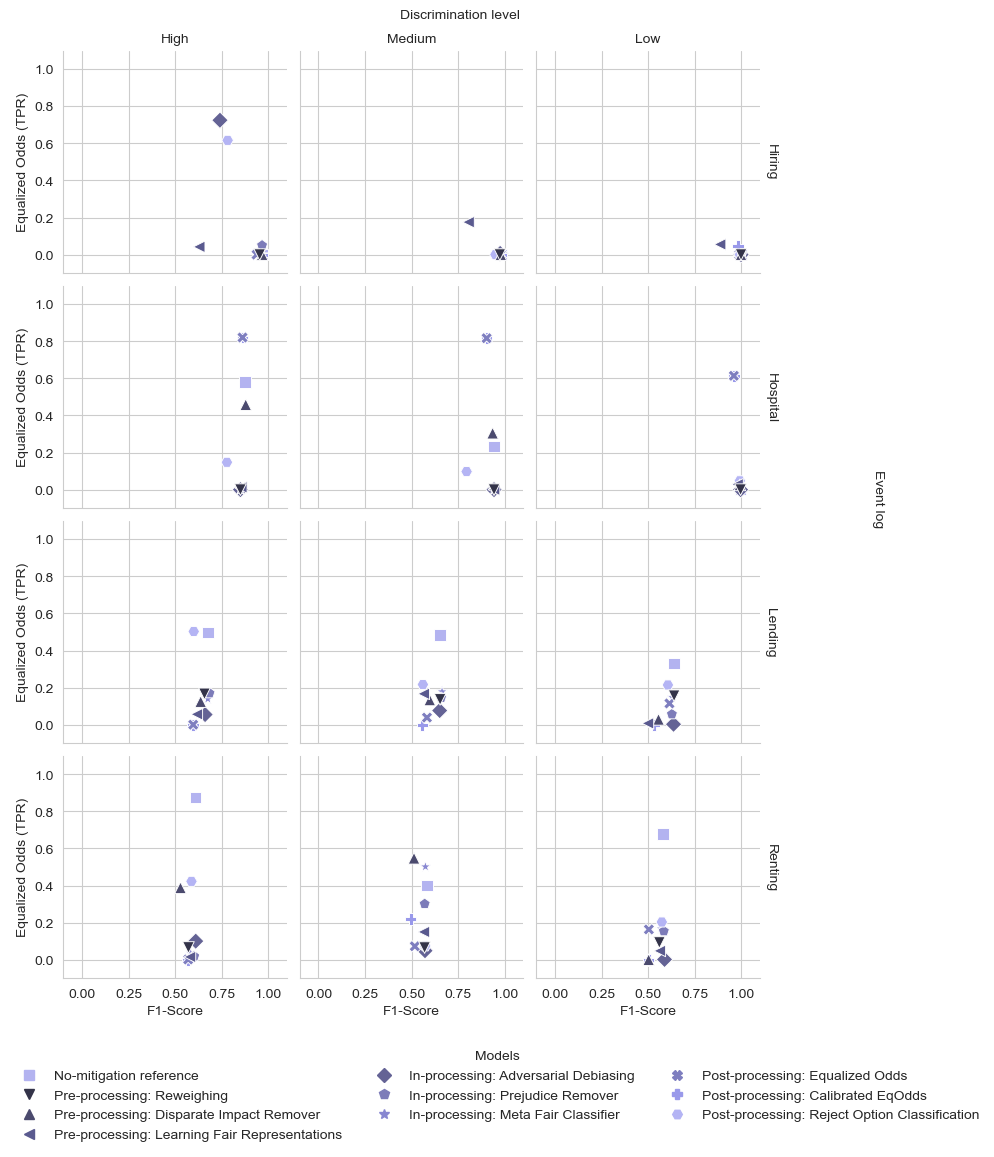

In [43]:
# df2 = df_results[(df_results['Model'] != 'Baseline')]
# df2 = df2[(df2['Model'] != 'Reference')]

# Filter out the 'Q&A reference' model for this plot
df2 = df_results[(df_results['Model'] != 'Q&A reference')]

# --- Dictionaries for plot styling ---

# Dictionary for markers
# Dictionary for markers
markers_dict = {
    #"Q&A reference": "o",
    "No-mitigation reference": "s",
    "Pre-processing: Reweighing": "v",                      
    "Pre-processing: Disparate Impact Remover": "^",      
    "Pre-processing: Learning Fair Representations": "<", 
    "In-processing: Adversarial Debiasing": "D", 
    "In-processing: Prejudice Remover": "p", 
    "In-processing: Meta Fair Classifier": "*", 
    "Post-processing: Equalized Odds": "X",                      
    "Post-processing: Calibrated EqOdds": "P",                 
    "Post-processing: Reject Option Classification": "H"       
}

# Dictionary for colors
colors_dict = {
    #"Q&A reference": "#1d1d27",
    "No-mitigation reference": "#b3b3f0",
    "Pre-processing: Reweighing": "#333349",
    "Pre-processing: Disparate Impact Remover": "#4b4a6e",
    "Pre-processing: Learning Fair Representations": "#5a5a8f",  
    "In-processing: Adversarial Debiasing": "#646395",
    "In-processing: Prejudice Remover": "#7d7cb9", 
    "In-processing: Meta Fair Classifier": "#8887d1",
    "Post-processing: Equalized Odds": "#7e7ebf",
    "Post-processing: Calibrated EqOdds": "#9999ea",
    "Post-processing: Reject Option Classification": "#b4b4f4" 
}

# ──────────────────────────────────────────────────────────────────────────────
# 1) PREPARE ALL LEGEND HANDLES
# ──────────────────────────────────────────────────────────────────────────────

# Handles for each model (using the same color and marker as the scatter plot)
model_handles = [
    Line2D([], [],                     # Empty list = nothing to plot
           marker=markers_dict[m],     # Model's marker
           color='none',               # Invisible line
           markerfacecolor=colors_dict[m],
           markeredgecolor=colors_dict[m],
           markersize=7,
           linestyle='',               # No line
           label=m)                    # Text for the legend
    for m in markers_dict
]

# Handle for the red dashed line (baseline) is commented out for this plot
# baseline_handle = Line2D([], [],
#                          color='red',
#                          linestyle='--',
#                          linewidth=1.5,
#                          label='Original data')

# Join all handles in a list (only model handles are used this time)
# legend_handles = [baseline_handle] + model_handles


# ──────────────────────────────────────────────────────────────────────────────
# 2) CREATE AND DRAW THE FACETGRID
# ──────────────────────────────────────────────────────────────────────────────

g = sns.FacetGrid(
    data=df2,
    row="Process",
    col="Base",
    margin_titles=True
)

def facet_scatter(data, **kwargs):
    # Draw the scatter plot points
    sns.scatterplot(
        data=data,
        x="F1-Score",
        y="Equalized Odds (TPR)",
        hue="Model",
        style="Model",
        markers=markers_dict,
        palette=colors_dict,
        s=70,
        **kwargs
    )

g.map_dataframe(facet_scatter)

# ──────────────────────────────────────────────────────────────────────────────
# 3) CUSTOMIZE LEGEND AND TITLES
# ──────────────────────────────────────────────────────────────────────────────

g.add_legend(
    handles=model_handles,           # Includes only model handles
    title="Models",                  # General title for the legend
    ncol=3,
    loc="upper center",
    bbox_to_anchor=(0.3, 0.15)
)

# Set axis limits
g.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))

# Remove "Process = " and "Base = " prefixes from facet titles
g.set_titles(row_template='{row_name}', col_template='{col_name}')

# Adjust space at the bottom to make room for the legend
plt.subplots_adjust(bottom=0.2)

# Add a general title for the "column axis"
g.fig.text(
    0.28,
    1.0,
    'Discrimination level', 
    ha='center'
)

# Add a general title for the "row axis"
g.fig.text(
    0.5,
    0.6,
    'Event log',
    va='center',
    rotation=-90
)

# Save and show the plot
plt.savefig("./Figures/fig_metric_EqualizedOdds_TPR.png", dpi=300, bbox_inches="tight")
plt.show()

Equalized Odds (FPR)

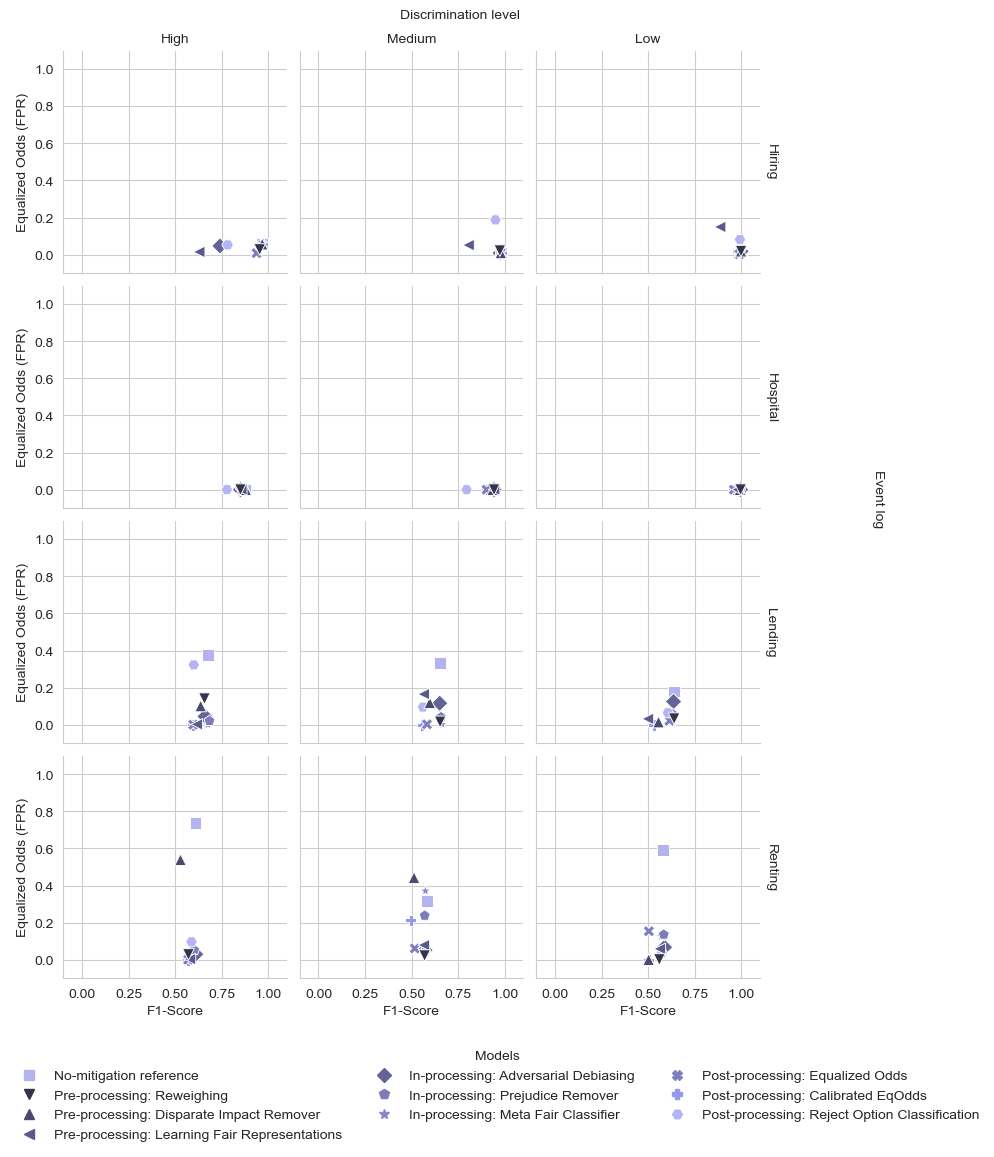

In [44]:
# df2 = df_results[(df_results['Model'] != 'Baseline')]
# df2 = df2[(df2['Model'] != 'Reference')]

# Filter out the 'Q&A reference' model for this plot
df2 = df_results[(df_results['Model'] != 'Q&A reference')]

# --- Dictionaries for plot styling ---

# Dictionary for markers
markers_dict = {
    #"Q&A reference": "o",
    "No-mitigation reference": "s",
    "Pre-processing: Reweighing": "v",                      
    "Pre-processing: Disparate Impact Remover": "^",      
    "Pre-processing: Learning Fair Representations": "<", 
    "In-processing: Adversarial Debiasing": "D", 
    "In-processing: Prejudice Remover": "p", 
    "In-processing: Meta Fair Classifier": "*", 
    "Post-processing: Equalized Odds": "X",                      
    "Post-processing: Calibrated EqOdds": "P",                 
    "Post-processing: Reject Option Classification": "H"       
}

# Dictionary for colors
colors_dict = {
    #"Q&A reference": "#1d1d27",
    "No-mitigation reference": "#b3b3f0",
    "Pre-processing: Reweighing": "#333349",
    "Pre-processing: Disparate Impact Remover": "#4b4a6e",
    "Pre-processing: Learning Fair Representations": "#5a5a8f",  
    "In-processing: Adversarial Debiasing": "#646395",
    "In-processing: Prejudice Remover": "#7d7cb9", 
    "In-processing: Meta Fair Classifier": "#8887d1",
    "Post-processing: Equalized Odds": "#7e7ebf",
    "Post-processing: Calibrated EqOdds": "#9999ea",
    "Post-processing: Reject Option Classification": "#b4b4f4" 
}

# ──────────────────────────────────────────────────────────────────────────────
# 1) PREPARE ALL LEGEND HANDLES
# ──────────────────────────────────────────────────────────────────────────────

# Handles for each model (using the same color and marker as the scatter plot)
model_handles = [
    Line2D([], [],                     # Empty list = nothing to plot
           marker=markers_dict[m],     # Model's marker
           color='none',               # Invisible line
           markerfacecolor=colors_dict[m],
           markeredgecolor=colors_dict[m],
           markersize=7,
           linestyle='',               # No line
           label=m)                    # Text for the legend
    for m in markers_dict
]

# Handle for the red dashed line (baseline) is commented out for this plot
# baseline_handle = Line2D([], [],
#                          color='red',
#                          linestyle='--',
#                          linewidth=1.5,
#                          label='Original data')

# Join all handles in a list (only model handles are used this time)
# legend_handles = [baseline_handle] + model_handles


# ──────────────────────────────────────────────────────────────────────────────
# 2) CREATE AND DRAW THE FACETGRID
# ──────────────────────────────────────────────────────────────────────────────

g = sns.FacetGrid(
    data=df2,
    row="Process",
    col="Base",
    margin_titles=True
)

def facet_scatter(data, **kwargs):
    # Draw the scatter plot points
    sns.scatterplot(
        data=data,
        x="F1-Score",
        y="Equalized Odds (FPR)", # The y-axis metric is changed here
        hue="Model",
        style="Model",
        markers=markers_dict,
        palette=colors_dict,
        s=70,
        **kwargs
    )

g.map_dataframe(facet_scatter)

# ──────────────────────────────────────────────────────────────────────────────
# 3) CUSTOMIZE LEGEND AND TITLES
# ──────────────────────────────────────────────────────────────────────────────

g.add_legend(
    handles=model_handles,           # Includes only model handles
    title="Models",                  # General title for the legend
    ncol=3,
    loc="upper center",
    bbox_to_anchor=(0.3, 0.15)
)

# Set axis limits
g.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))

# Remove "Process = " and "Base = " prefixes from facet titles
g.set_titles(row_template='{row_name}', col_template='{col_name}')

# Adjust space at the bottom to make room for the legend
plt.subplots_adjust(bottom=0.2)

# Add a general title for the "column axis"
g.fig.text(
    0.28,
    1.0,
    'Discrimination level',
    ha='center'
)

# Add a general title for the "row axis"
g.fig.text(
    0.5,
    0.6,
    'Event log',
    va='center',
    rotation=-90
)

# Save and show the plot
plt.savefig("./Figures/fig_metric_EqualizedOdds_FPR.png", dpi=300, bbox_inches="tight")
plt.show()